<a href="https://colab.research.google.com/github/juacastanori/TAM/blob/main/Taller_5_Junio/TAM_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


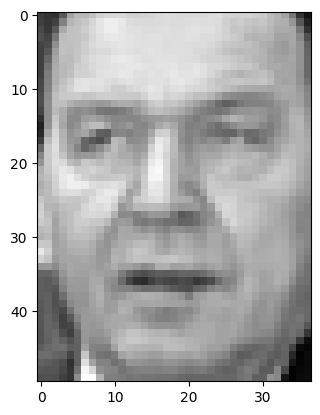

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

0         1         2         3         4         5         6     \
510   0.000836  0.001143  0.001446  0.001666  0.001897  0.001994  0.002066   
1035  0.001589  0.001758  0.001922  0.002409  0.002819  0.002958  0.002917   
176   0.000892  0.001205  0.001210  0.001287  0.001492  0.001687  0.001763   
620   0.000267  0.000584  0.001446  0.002230  0.002507  0.002512  0.002491   
689   0.002261  0.002409  0.001958  0.001753  0.002127  0.002907  0.002932   

          7         8         9     ...      1840      1841      1842  \
510   0.002071  0.002097  0.002138  ...  0.000549  0.001384  0.002332   
1035  0.002830  0.002830  0.002737  ...  0.000297  0.000374  0.000384   
176   0.001779  0.001845  0.001866  ...  0.000451  0.000446  0.000482   
620   0.002532  0.002584  0.002594  ...  0.001333  0.001389  0.000723   
689   0.002676  0.002655  0.002799  ...  0.001569  0.001512  0.001548   

          1843      1844      1845      1846      1847      1848      1849  
510   0.003189  0.003645  0.003727  0.003101  0.000856  0.000395  0.000466  
1035  0.000436  0.000359  0.000369  0.000420  0.000497  0.000466  0.000466  
176   0.000472  0.000477  0.000466  0.000513  0.000559  0.000600  0.000538  
620   0.000133  0.000190  0.000251  0.000313  0.000400  0.000549  0.000666  
689   0.001615  0.001794  0.002276  0.003106  0.003522  0.003573  0.003578  

[5 rows x 1850 columns]

# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

Modelos y problema de optimización:

## 🔢 Funciones de costo y modelo de predicción para cada clasificador

---

### **1. Regresión Logística (multiclase con softmax)**

**Modelo de predicción:**

$$
\hat{y}_k = P(y = k \mid \mathbf{x}) = \frac{e^{\mathbf{w}_k^\top \mathbf{x}}}{\sum_{j=1}^{K} e^{\mathbf{w}_j^\top \mathbf{x}}}
$$

**Función de costo (cross-entropy con regularización L2):**

$$
J(\mathbf{W}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log\left( \frac{e^{\mathbf{w}_k^\top \mathbf{x}_i}}{\sum_{j=1}^{K} e^{\mathbf{w}_j^\top \mathbf{x}_i}} \right) + \frac{\lambda}{2} \sum_{k=1}^{K} \|\mathbf{w}_k\|^2
$$

**Hiperparámetro a ajustar:**

$$
C = \text{inversa de la regularización} \quad (\lambda = \frac{1}{C})
$$

---

### **2. SGDClassifier**

**Opción A: Hinge Loss (SVM lineal)**

$$
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N \max(0, 1 - y_i (\mathbf{w}^\top \mathbf{x}_i)) + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

**Opción B: Log Loss (Regresión logística)**

$$
J(\mathbf{w}) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log \hat{y}_i + (1 - y_i) \log(1 - \hat{y}_i) \right] + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

**Hiperparámetro a ajustar:**

$$
\alpha = \lambda \quad (\text{regularización L2})
$$

---

### **3. SVC con kernel RBF**

**Función de decisión (modelo):**

$$
f(\mathbf{x}) = \sum_{i=1}^N \alpha_i y_i \, K(\mathbf{x}_i, \mathbf{x}) + b
$$

donde el kernel gaussiano es:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2 \right)
$$

**Problema de optimización dual:**

$$
\min_{\boldsymbol{\alpha}} \; \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) - \sum_{i=1}^N \alpha_i
$$

sujeto a:

$$
0 \leq \alpha_i \leq C, \quad \sum_{i=1}^N \alpha_i y_i = 0
$$

**Hiperparámetros a ajustar:**

- $$ C \quad \text{(controla la penalización por errores)} $$
- $$ \gamma \quad \text{(define el ancho del kernel RBF)} $$



In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

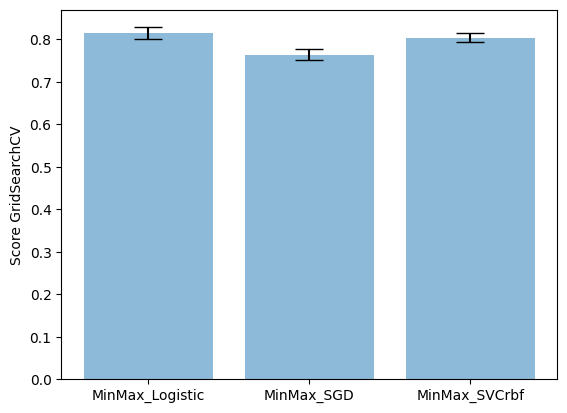

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.764 0.804]
 [0.014 0.013 0.011]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


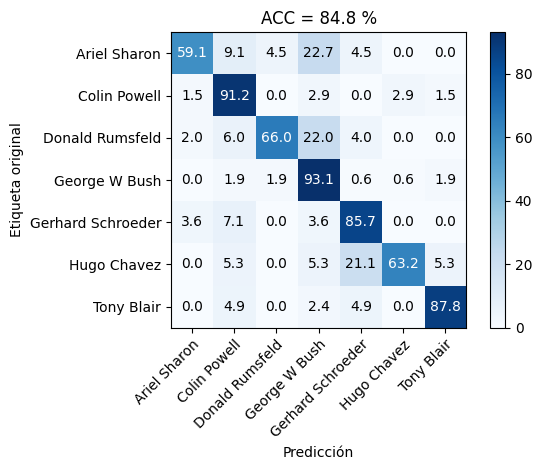

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


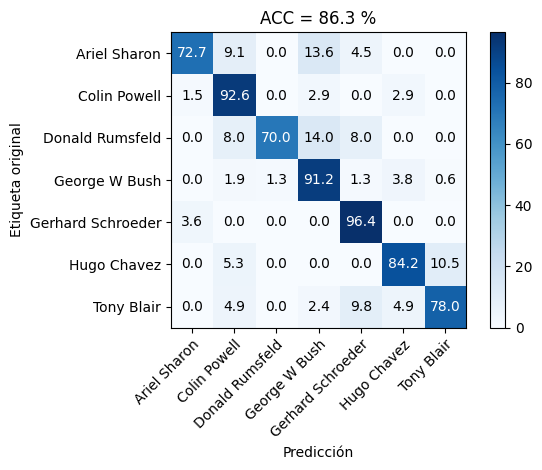

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        22
     Colin Powell       0.84      0.93      0.88        68
  Donald Rumsfeld       0.95      0.70      0.80        50
    George W Bush       0.92      0.91      0.91       159
Gerhard Schroeder       0.71      0.96      0.82        28
      Hugo Chavez       0.62      0.84      0.71        19
       Tony Blair       0.91      0.78      0.84        41

         accuracy                           0.86       387
        macro avg       0.83      0.84      0.82       387
     weighted avg       0.88      0.86      0.86       387

Evaluando modelo MinMax_SVCrbf (3/3)


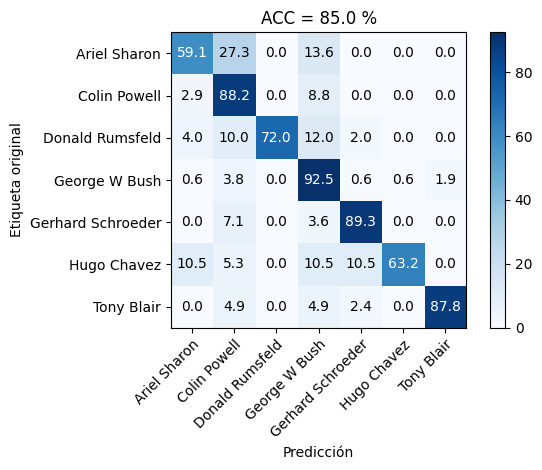

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


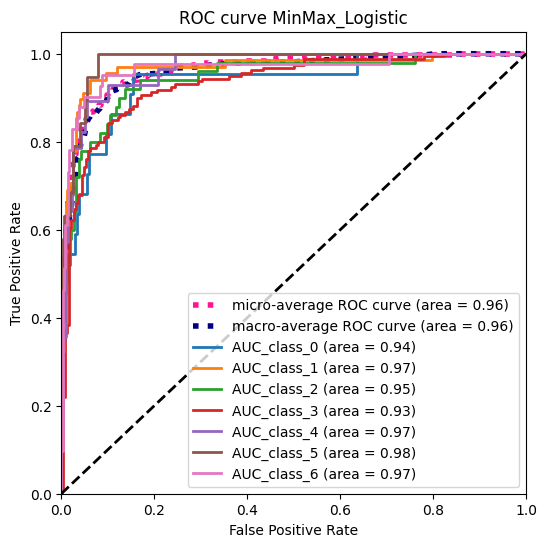

Evaluando modelo MinMax_SGD (2/3)


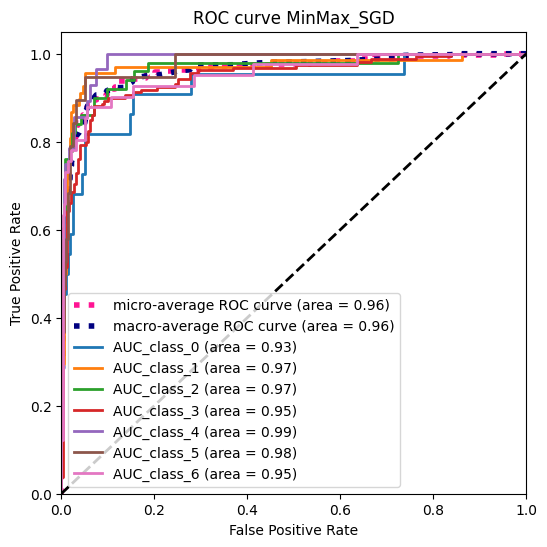

Evaluando modelo MinMax_SVCrbf (3/3)


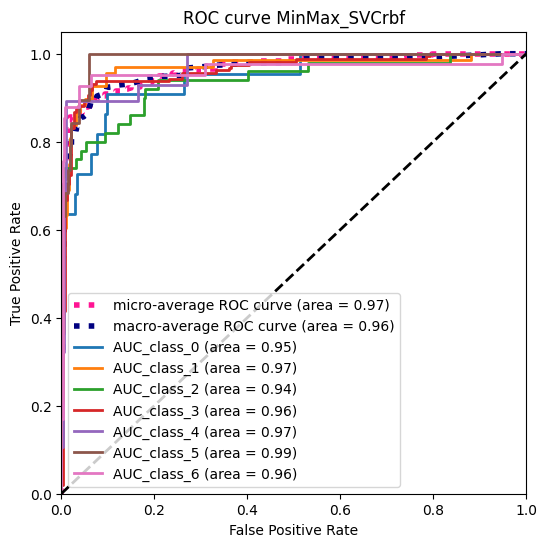

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


## 📌 Ejercicio 1: Modelos y problemas de optimización

---

### 🔹 1. Gaussian Naive Bayes (`GaussianNB`)

**Modelo:**

Asume que para cada clase \( y = k \), las características \( x_j \) son independientes y siguen una distribución normal:

$$
P(x_j \mid y = k) = \mathcal{N}(x_j \mid \mu_{jk}, \sigma^2_{jk})
$$

**Predicción (regla de Bayes):**

$$
\hat{y} = \arg\max_k \; P(y = k) \prod_{j=1}^{d} P(x_j \mid y = k)
$$

**Optimización:**  
No hay una función de costo como tal, se estiman los parámetros $ \mu_{jk}, \sigma^2_{jk}$  y $P(y=k)$ directamente de los datos (estimación máxima verosímil).

**Hiperparámetros:**  
- `var_smoothing`: constante que se añade a la varianza para estabilidad numérica.

---

### 🔹 2. SGDClassifier (`SGDClassifier`)

**Modelo:**

Minimiza una función de pérdida elegida sobre muestras individuales, usando descenso de gradiente estocástico:

**Ejemplo con hinge loss (SVM):**

$$
J(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N \max(0, 1 - y_i \mathbf{w}^\top \mathbf{x}_i) + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

**O con log loss (regresión logística):**

$$
J(\mathbf{w}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right] + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

**Hiperparámetros:**
- `loss`: tipo de pérdida (`hinge`, `log_loss`, etc.)
- `alpha`: regularización L2 $\lambda$
- `penalty`: tipo de regularización (`l2`, `l1`, `elasticnet`)
- `learning_rate`: tasa de aprendizaje (`optimal`, `invscaling`, etc.)

---

### 🔹 3. Regresión Logística (`LogisticRegression`)

**Modelo (multiclase con softmax):**

$$
P(y = k \mid \mathbf{x}) = \frac{e^{\mathbf{w}_k^\top \mathbf{x}}}{\sum_{j=1}^K e^{\mathbf{w}_j^\top \mathbf{x}}}
$$

**Función de costo (cross-entropy):**

$$
J(\mathbf{W}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log \left( P(y = k \mid \mathbf{x}_i) \right) + \frac{\lambda}{2} \sum_{k=1}^{K} \|\mathbf{w}_k\|^2
$$

**Hiperparámetros:**
- `C`: inversa de la regularización $\lambda = 1/C$
- `penalty`: tipo de regularización (`l2`, `l1`, `elasticnet`)
- `solver`: algoritmo de optimización (`lbfgs`, `liblinear`, etc.)

---

### 🔹 4. Análisis Discriminante Lineal (`LinearDiscriminantAnalysis`)

**Modelo:**

Proyecta los datos sobre una línea que maximiza la separación entre clases:

$$
\hat{y} = \arg\max_k \; \log P(y = k) - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}_k)
$$

**Optimización:**

Maximiza la razón de Fisher:

$$
\text{Fisher} = \frac{|\mathbf{w}^\top S_B \mathbf{w}|}{|\mathbf{w}^\top S_W \mathbf{w}|}
$$

- $S_B$: matriz de dispersión entre clases
- $S_W$: matriz de dispersión dentro de clases

**Hiperparámetros:**
- `solver`: tipo de solucionador (`svd`, `lsqr`, `eigen`)
- `shrinkage`: regularización de la covarianza

---

### 🔹 5. K-Vecinos más cercanos (`KNeighborsClassifier`)

**Modelo:**

No paramétrico. Clasifica una muestra según la mayoría de votos de sus \(k\) vecinos más cercanos:

$$
\hat{y} = \text{majority\_vote}( \{ y_i : \mathbf{x}_i \in \mathcal{N}_k(\mathbf{x}) \} )
$$

**Optimización:**  
No tiene entrenamiento formal, solo almacena el conjunto de entrenamiento.

**Hiperparámetros:**
- `n_neighbors` = $k$
- `weights`: tipo de ponderación (`uniform`, `distance`)
- `metric`: métrica de distancia (`euclidean`, `manhattan`, etc.)

---

### 🔹 6. SVM lineal (`LinearSVC`)

**Modelo:**

Clasificador SVM lineal que resuelve el problema primal (no dual):

$$
\min_{\mathbf{w}, b} \; \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^N \xi_i
$$

sujeto a:

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

**Hiperparámetros:**
- `C`: parámetro de penalización
- `loss`: función de pérdida (`hinge`, `squared_hinge`)
- `penalty`: tipo de regularización (`l1`, `l2`)

---

### 🔹 7. SVM con kernel (`SVC`)

**Modelo:**

Clasificador SVM que usa un kernel (por defecto RBF):

$$
f(\mathbf{x}) = \sum_{i=1}^N \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b
$$

**Problema dual:**

$$
\min_{\boldsymbol{\alpha}} \; \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) - \sum_i \alpha_i
$$

sujeto a:

$$
0 \leq \alpha_i \leq C, \quad \sum_i \alpha_i y_i = 0
$$

**Hiperparámetros:**
- `C`: penalización por error
- `kernel`: tipo de núcleo (`rbf`, `poly`, etc.)
- `gamma`: controla la forma del kernel RBF

---

### 🔹 8. Random Forest (`RandomForestClassifier`)

**Modelo:**

Conjunto de árboles de decisión entrenados sobre subconjuntos aleatorios del dataset y características.

**Predicción:**

$$
\hat{y} = \text{majority\_vote}( \{ h_t(\mathbf{x}) \}_{t=1}^T )
$$

donde $h_t$ es el árbol $t$-ésimo.

**Optimización:**  
Minimiza el **impurity (Gini/entropy)** en cada nodo del árbol.

**Hiperparámetros:**
- `n_estimators`: número de árboles
- `max_depth`: profundidad máxima
- `max_features`: número de características por nodo
- `criterion`: función de impureza (`gini`, `entropy`)


## Ejercicio 2: Optimización bayesiana (Optuna) + CV 5 folds

In [ ]:
!pip install optuna -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.6 MB/s eta 0:00:00


Naive Bayes
Nota: para AUC_score, el clasificador Naive_bayes da un error

In [ ]:
# --- IMPORTACIONES ---
import optuna
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from functools import partial

# --- VALIDACIÓN CRUZADA ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- FUNCIÓN OBJETIVO (sin AUC) ---
def objective(trial, X, y, scoring):

    # Rango robusto para var_smoothing
    var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e-6, log=True)

    # Pipeline: escalado + modelo
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', GaussianNB(var_smoothing=var_smoothing))
    ])

    # Validación cruzada según métrica
    score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()

    # Si hay error, descartar
    if np.isnan(score):
        raise optuna.exceptions.TrialPruned()

    return score

# --- EJECUCIÓN DEL ESTUDIO PARA ACCURACY Y F1 ---
resultados_gnb = {}

for metric in ['accuracy', 'f1_macro']:
    print(f"🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=30, timeout=300)

    if len(study.trials) > 0 and any([t.state.name == 'COMPLETE' for t in study.trials]):
        resultados_gnb[metric] = {
            'mejor_score': study.best_value,
            'mejores_hiperparametros': study.best_params
        }
    else:
        print(f"⚠️ No se encontraron resultados válidos para la métrica: {metric}")


[I 2025-06-02 21:58:38,314] A new study created in memory with name: no-name-3b668bcb-5ead-47ab-81b6-d344f75f458f


🔍 Optimizando para: accuracy


[I 2025-06-02 21:58:38,885] Trial 0 finished with value: 0.3684407612031921 and parameters: {'var_smoothing': 2.571779248692632e-07}. Best is trial 0 with value: 0.3684407612031921.
[I 2025-06-02 21:58:39,288] Trial 1 finished with value: 0.3684407612031921 and parameters: {'var_smoothing': 5.20285321076966e-08}. Best is trial 0 with value: 0.3684407612031921.
[I 2025-06-02 21:58:39,845] Trial 2 finished with value: 0.3684407612031921 and parameters: {'var_smoothing': 1.4679253256624185e-07}. Best is trial 0 with value: 0.3684407612031921.
[I 2025-06-02 21:58:40,405] Trial 3 finished with value: 0.3684407612031921 and parameters: {'var_smoothing': 1.289102045717889e-09}. Best is trial 0 with value: 0.3684407612031921.
[I 2025-06-02 21:58:41,164] Trial 4 finished with value: 0.3684407612031921 and parameters: {'var_smoothing': 2.571564820166296e-07}. Best is trial 0 with value: 0.3684407612031921.
[I 2025-06-02 21:58:41,808] Trial 5 finished with value: 0.3684407612031921 and parameters

🔍 Optimizando para: f1_macro


[I 2025-06-02 21:59:02,772] Trial 0 finished with value: 0.34644742919898175 and parameters: {'var_smoothing': 2.2528048575227447e-08}. Best is trial 0 with value: 0.34644742919898175.
[I 2025-06-02 21:59:03,496] Trial 1 finished with value: 0.34644742919898175 and parameters: {'var_smoothing': 4.8207810195287313e-08}. Best is trial 0 with value: 0.34644742919898175.
[I 2025-06-02 21:59:04,002] Trial 2 finished with value: 0.34644742919898175 and parameters: {'var_smoothing': 1.0481828797248673e-09}. Best is trial 0 with value: 0.34644742919898175.
[I 2025-06-02 21:59:04,670] Trial 3 finished with value: 0.34644742919898175 and parameters: {'var_smoothing': 8.660364322767087e-07}. Best is trial 0 with value: 0.34644742919898175.
[I 2025-06-02 21:59:05,321] Trial 4 finished with value: 0.34644742919898175 and parameters: {'var_smoothing': 1.552771865676553e-09}. Best is trial 0 with value: 0.34644742919898175.
[I 2025-06-02 21:59:05,791] Trial 5 finished with value: 0.34644742919898175 

In [ ]:
from pprint import pprint
print("📌 Resultados finales para GaussianNB optimizado:")
pprint(resultados_gnb)


📌 Resultados finales para GaussianNB optimizado:
{'accuracy': {'mejor_score': 0.3684407612031921,
              'mejores_hiperparametros': {'var_smoothing': 2.571779248692632e-07}},
 'f1_macro': {'mejor_score': 0.34644742919898175,
              'mejores_hiperparametros': {'var_smoothing': 2.2528048575227447e-08}}}



📊 Evaluación para modelo optimizado por: accuracy


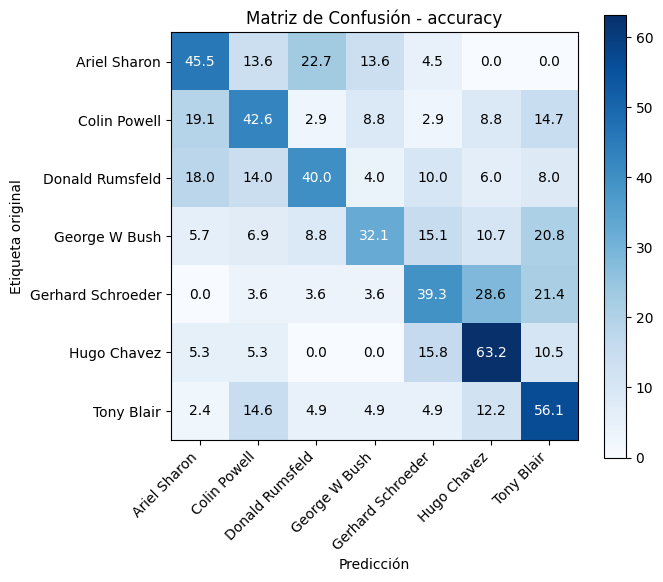

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387


📊 Evaluación para modelo optimizado por: f1_macro


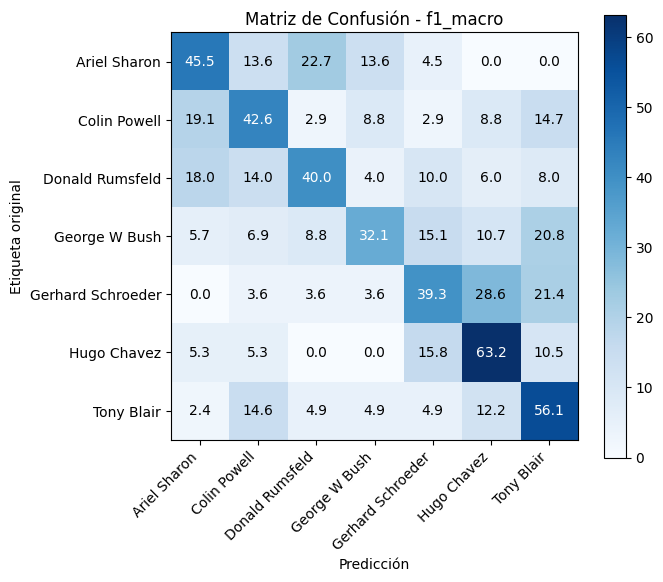

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387



In [ ]:
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

# Mostrar nombres reales de las clases
target_names = lfw_people.target_names

# === Matriz de confusión normalizada y reporte ===
for metric in resultados_gnb:
    print(f"\n📊 Evaluación para modelo optimizado por: {metric}")

    var_smoothing_opt = resultados_gnb[metric]['mejores_hiperparametros']['var_smoothing']
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', GaussianNB(var_smoothing=var_smoothing_opt))
    ])
    model.fit(Xtrain, ytrain)

    # Predicción sobre Xtest
    y_pred = model.predict(Xtest)

    # --- Matriz de confusión normalizada por fila (clase verdadera) ---
    cm = confusion_matrix(ytest, y_pred, normalize='true') * 100  # porcentajes
    labels = target_names[unique_labels(ytest, y_pred)]

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        title=f'Matriz de Confusión - {metric}',
        ylabel='Etiqueta original',
        xlabel='Predicción'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

    # --- Reporte clasificación ---
    print(classification_report(ytest, y_pred, target_names=target_names))


📈 Curvas ROC para modelo optimizado por: accuracy


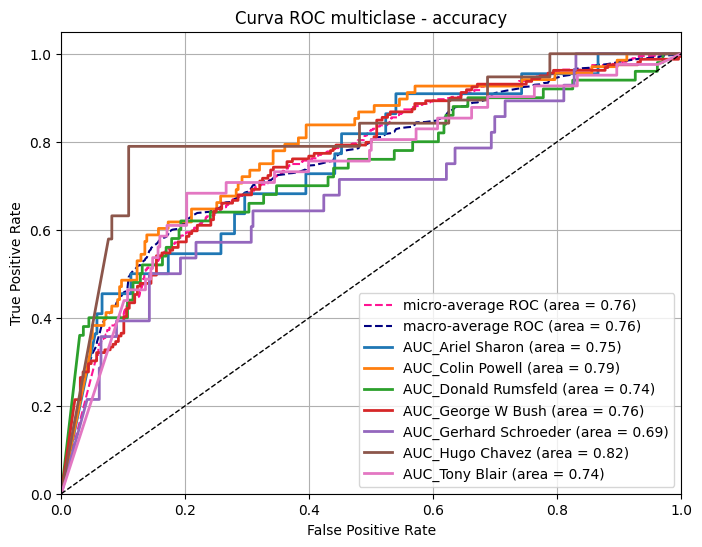

📈 Curvas ROC para modelo optimizado por: f1_macro


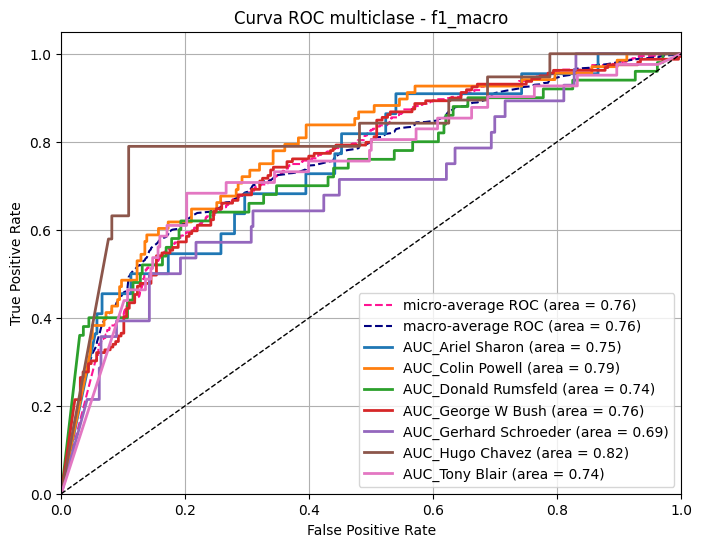

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Volver a binarizar para seguridad
classes = np.unique(ytest)
ytest_bin = label_binarize(ytest, classes=classes)
n_classes = len(target_names)

for metric in resultados_gnb:
    print(f"📈 Curvas ROC para modelo optimizado por: {metric}")

    # Reconstruir modelo
    var_smoothing_opt = resultados_gnb[metric]['mejores_hiperparametros']['var_smoothing']
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', GaussianNB(var_smoothing=var_smoothing_opt))
    ])
    model.fit(Xtrain, ytrain)

    # Score sobre conjunto de test
    y_score = model.predict_proba(Xtest)

    # Curvas ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Curva promedio macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Curva promedio micro
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # --- Graficar ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='deeppink',
             label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})')
    plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='navy',
             label=f'macro-average ROC (area = {roc_auc["macro"]:.2f})')

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'AUC_{target_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC multiclase - {metric}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


SGDClassifier

[I 2025-06-02 22:08:11,243] A new study created in memory with name: no-name-eabbbe82-ff2a-4b9a-85df-f98c76143131



🔍 Optimizando para: accuracy


[I 2025-06-02 22:08:18,210] Trial 0 finished with value: 0.7457949662369552 and parameters: {'loss': 'log_loss', 'alpha': 5.808444419444098e-05}. Best is trial 0 with value: 0.7457949662369552.
[I 2025-06-02 22:08:21,859] Trial 1 finished with value: 0.7269797421731122 and parameters: {'loss': 'hinge', 'alpha': 0.0015498236853051627}. Best is trial 0 with value: 0.7457949662369552.
[I 2025-06-02 22:08:25,239] Trial 2 finished with value: 0.7269429097605894 and parameters: {'loss': 'modified_huber', 'alpha': 0.00010633112445452184}. Best is trial 0 with value: 0.7457949662369552.
[I 2025-06-02 22:08:29,727] Trial 3 finished with value: 0.7603130755064458 and parameters: {'loss': 'hinge', 'alpha': 0.004833699565117175}. Best is trial 3 with value: 0.7603130755064458.
[I 2025-06-02 22:08:33,084] Trial 4 finished with value: 0.7147206875383671 and parameters: {'loss': 'log_loss', 'alpha': 3.211263453863647e-06}. Best is trial 3 with value: 0.7603130755064458.
[I 2025-06-02 22:08:36,724] Tr


🔍 Optimizando para: f1_macro


[I 2025-06-02 22:11:16,279] Trial 0 finished with value: 0.697255205889266 and parameters: {'loss': 'log_loss', 'alpha': 2.5448889532615647e-06}. Best is trial 0 with value: 0.697255205889266.
[I 2025-06-02 22:11:21,328] Trial 1 finished with value: 0.6308618732777252 and parameters: {'loss': 'log_loss', 'alpha': 1.1964662589999234e-05}. Best is trial 0 with value: 0.697255205889266.
[I 2025-06-02 22:11:28,402] Trial 2 finished with value: 0.7333760452862483 and parameters: {'loss': 'log_loss', 'alpha': 0.0021277679541291954}. Best is trial 2 with value: 0.7333760452862483.
[I 2025-06-02 22:11:36,718] Trial 3 finished with value: 0.6784206312629834 and parameters: {'loss': 'log_loss', 'alpha': 0.0003197919177530246}. Best is trial 2 with value: 0.7333760452862483.
[I 2025-06-02 22:11:40,153] Trial 4 finished with value: 0.6944830793565577 and parameters: {'loss': 'hinge', 'alpha': 1.5697469047196888e-05}. Best is trial 2 with value: 0.7333760452862483.
[I 2025-06-02 22:11:47,217] Trial


🔍 Optimizando para: roc_auc_ovr


[I 2025-06-02 22:14:20,179] Trial 0 pruned. 
[I 2025-06-02 22:14:24,489] Trial 1 finished with value: 0.878516283673051 and parameters: {'loss': 'modified_huber', 'alpha': 0.005402927973186681}. Best is trial 1 with value: 0.878516283673051.
[I 2025-06-02 22:14:28,187] Trial 2 pruned. 
[I 2025-06-02 22:14:35,867] Trial 3 pruned. 
[I 2025-06-02 22:14:39,635] Trial 4 finished with value: 0.867654150479995 and parameters: {'loss': 'modified_huber', 'alpha': 0.0011461684657583392}. Best is trial 1 with value: 0.878516283673051.
[I 2025-06-02 22:14:46,786] Trial 5 finished with value: 0.9160286477076477 and parameters: {'loss': 'log_loss', 'alpha': 0.00012552633459850205}. Best is trial 5 with value: 0.9160286477076477.
[I 2025-06-02 22:14:51,098] Trial 6 finished with value: 0.8861959886750036 and parameters: {'loss': 'modified_huber', 'alpha': 0.004135119001899809}. Best is trial 5 with value: 0.9160286477076477.
[I 2025-06-02 22:14:54,859] Trial 7 pruned. 
[I 2025-06-02 22:14:58,305] Tri


📊 Evaluación para modelo optimizado por: accuracy


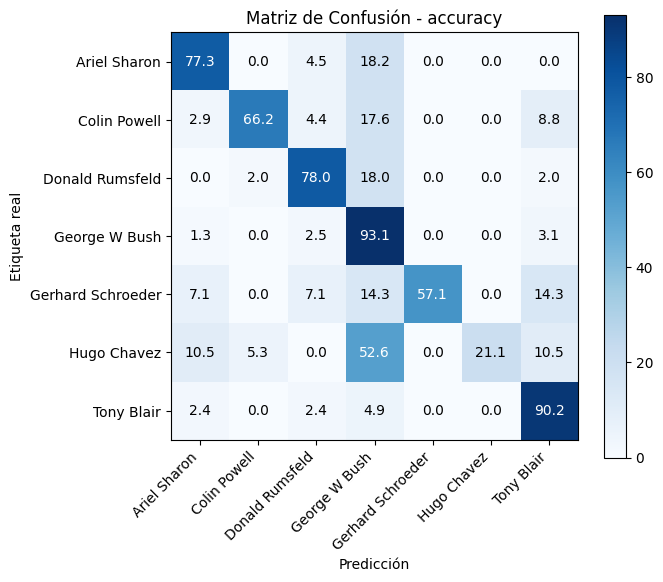

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.77      0.71        22
     Colin Powell       0.96      0.66      0.78        68
  Donald Rumsfeld       0.78      0.78      0.78        50
    George W Bush       0.78      0.93      0.85       159
Gerhard Schroeder       1.00      0.57      0.73        28
      Hugo Chavez       1.00      0.21      0.35        19
       Tony Blair       0.67      0.90      0.77        41

         accuracy                           0.79       387
        macro avg       0.84      0.69      0.71       387
     weighted avg       0.82      0.79      0.78       387


📈 Curvas ROC para: accuracy


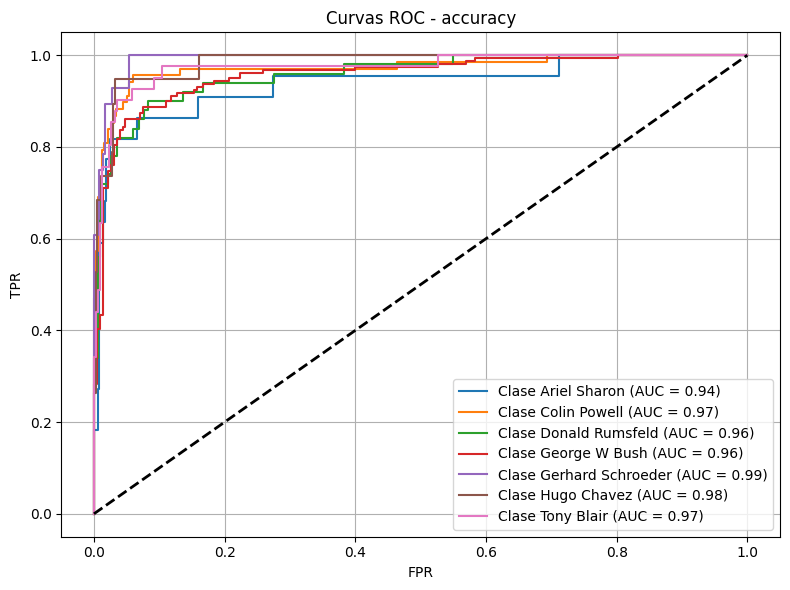


📊 Evaluación para modelo optimizado por: f1_macro


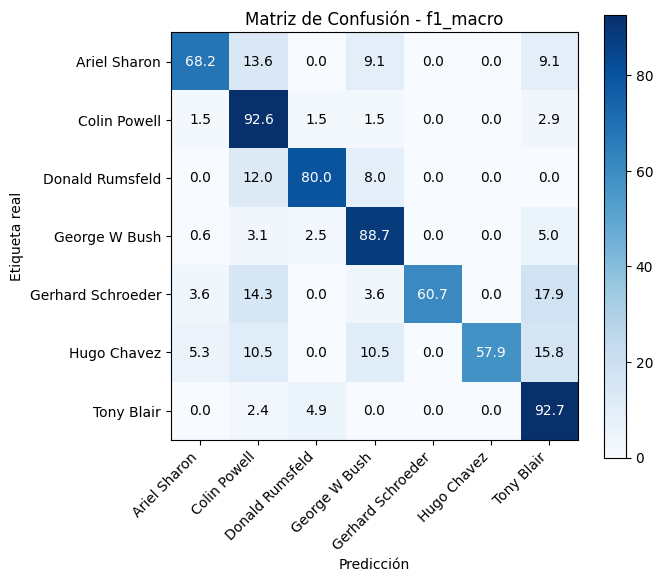

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.68      0.73        22
     Colin Powell       0.75      0.93      0.83        68
  Donald Rumsfeld       0.85      0.80      0.82        50
    George W Bush       0.93      0.89      0.91       159
Gerhard Schroeder       1.00      0.61      0.76        28
      Hugo Chavez       1.00      0.58      0.73        19
       Tony Blair       0.66      0.93      0.77        41

         accuracy                           0.84       387
        macro avg       0.85      0.77      0.79       387
     weighted avg       0.86      0.84      0.84       387


📈 Curvas ROC para: f1_macro


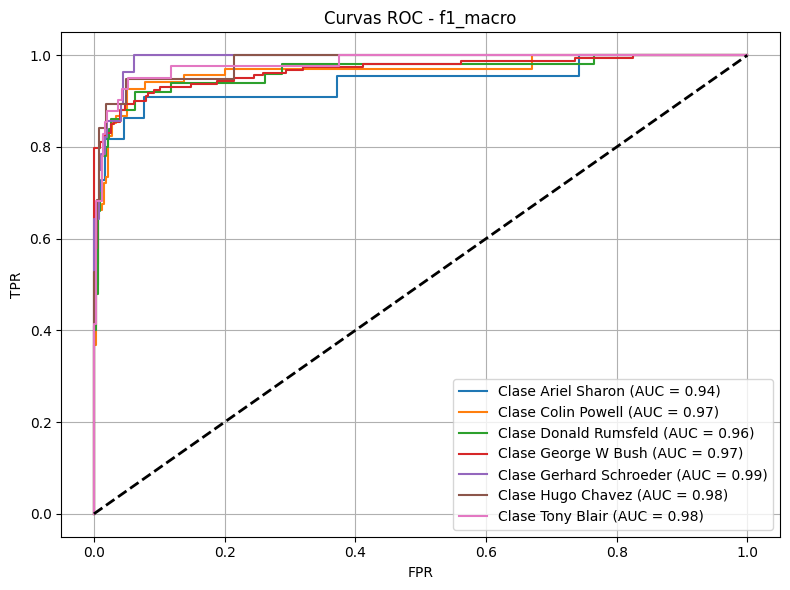


📊 Evaluación para modelo optimizado por: roc_auc_ovr


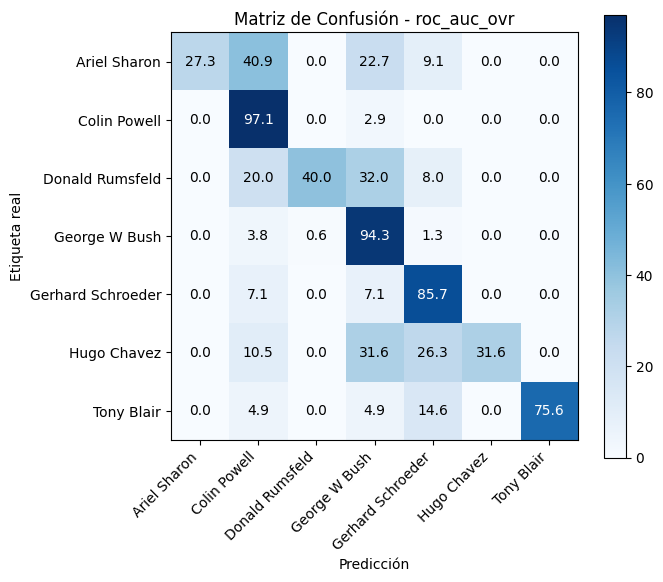

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.27      0.43        22
     Colin Powell       0.68      0.97      0.80        68
  Donald Rumsfeld       0.95      0.40      0.56        50
    George W Bush       0.82      0.94      0.88       159
Gerhard Schroeder       0.56      0.86      0.68        28
      Hugo Chavez       1.00      0.32      0.48        19
       Tony Blair       1.00      0.76      0.86        41

         accuracy                           0.78       387
        macro avg       0.86      0.65      0.67       387
     weighted avg       0.83      0.78      0.76       387


📈 Curvas ROC para: roc_auc_ovr


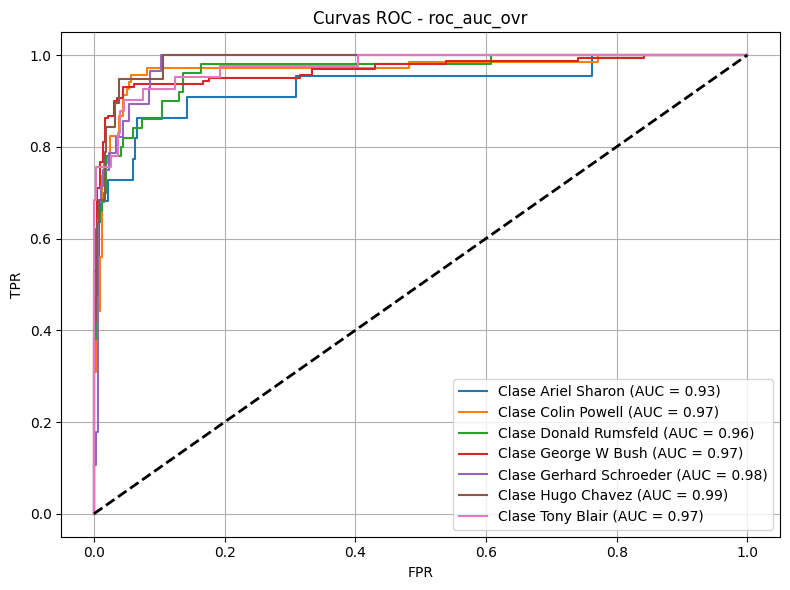

In [ ]:
# --- IMPORTACIONES ---
import optuna
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.exceptions import NotFittedError
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# --- VALIDACION CRUZADA ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- FUNCIÓN OBJETIVO ---
def objective(trial, X, y, scoring):
    loss = trial.suggest_categorical("loss", ["hinge", "log_loss", "modified_huber"])
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)

    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', SGDClassifier(loss=loss, alpha=alpha, random_state=42, max_iter=1000, tol=1e-3))
    ])

    score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()

    if np.isnan(score):
        raise optuna.exceptions.TrialPruned()

    return score

# --- OPTIMIZACIÓN ---
resultados_sgd = {}
for metric in ['accuracy', 'f1_macro', 'roc_auc_ovr']:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=30, timeout=300)

    if len(study.trials) > 0 and any(t.state.name == 'COMPLETE' for t in study.trials):
        resultados_sgd[metric] = {
            'mejor_score': study.best_value,
            'mejores_hiperparametros': study.best_params
        }
    else:
        print(f"⚠️ No se encontraron resultados válidos para la métrica: {metric}")

# --- EVALUACIÓN FINAL ---
from sklearn.utils.multiclass import unique_labels

target_names = lfw_people.target_names

for metric in resultados_sgd:
    print(f"\n📊 Evaluación para modelo optimizado por: {metric}")
    best_params = resultados_sgd[metric]['mejores_hiperparametros']

    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', SGDClassifier(**best_params, random_state=42, max_iter=1000, tol=1e-3))
    ])
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)

    # === MATRIZ DE CONFUSIÓN ===
    cm = confusion_matrix(ytest, y_pred, normalize='true') * 100
    labels = target_names[unique_labels(ytest, y_pred)]

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        title=f'Matriz de Confusión - {metric}',
        ylabel='Etiqueta real',
        xlabel='Predicción'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

    # === REPORTE DE CLASIFICACIÓN ===
    print(classification_report(ytest, y_pred, target_names=target_names))

    # === CURVAS ROC ===
    print("\n📈 Curvas ROC para:", metric)
    ytest_bin = label_binarize(ytest, classes=np.unique(ytrain))
    try:
        y_score = model.predict_proba(Xtest)
    except AttributeError:
        y_score = model.decision_function(Xtest)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # === PLOT ===
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(len(target_names)):
        ax.plot(fpr[i], tpr[i], label=f"Clase {target_names[i]} (AUC = {roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(xlabel='FPR', ylabel='TPR', title=f'Curvas ROC - {metric}')
    ax.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()




LogisticRegressor

[I 2025-06-02 22:40:35,624] A new study created in memory with name: no-name-12efe55c-af67-4dc8-943c-4c31e59d9bb4



🔍 Optimizando para: accuracy


[I 2025-06-02 22:40:45,410] Trial 0 finished with value: 0.7813321055862492 and parameters: {'solver': 'lbfgs', 'C': 0.14770050118339859}. Best is trial 0 with value: 0.7813321055862492.
[I 2025-06-02 22:40:56,220] Trial 1 finished with value: 0.8002087170042971 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.34379927569768326}. Best is trial 1 with value: 0.8002087170042971.
[I 2025-06-02 22:41:02,254] Trial 2 finished with value: 0.813523634131369 and parameters: {'solver': 'lbfgs', 'C': 26.810039470194663}. Best is trial 2 with value: 0.813523634131369.
[I 2025-06-02 22:41:09,197] Trial 3 finished with value: 0.8157458563535911 and parameters: {'solver': 'lbfgs', 'C': 17.73376363221514}. Best is trial 3 with value: 0.8157458563535911.
[I 2025-06-02 22:41:25,889] Trial 4 finished with value: 0.8080110497237568 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 67.40551018419414}. Best is trial 3 with value: 0.8157458563535911.
[I 2025-06-02 22:41:28,540] Tr


🔍 Optimizando para: f1_macro


[I 2025-06-02 22:44:21,111] Trial 0 finished with value: 0.769858578080928 and parameters: {'solver': 'lbfgs', 'C': 1.8139529215589405}. Best is trial 0 with value: 0.769858578080928.
[I 2025-06-02 22:44:24,729] Trial 1 finished with value: 0.4668949011693047 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3364226274614307}. Best is trial 0 with value: 0.769858578080928.
[I 2025-06-02 22:44:39,305] Trial 2 finished with value: 0.7511121480702732 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.171749960549858}. Best is trial 0 with value: 0.769858578080928.
[I 2025-06-02 22:44:49,040] Trial 3 finished with value: 0.7712300839123726 and parameters: {'solver': 'lbfgs', 'C': 2.1443646214979784}. Best is trial 3 with value: 0.7712300839123726.
[I 2025-06-02 22:44:56,498] Trial 4 finished with value: 0.7400170663590686 and parameters: {'solver': 'lbfgs', 'C': 0.24696384741988608}. Best is trial 3 with value: 0.7712300839123726.
[I 2025-06-02 22:45:02,385] Tria


🔍 Optimizando para: roc_auc_ovr


[I 2025-06-02 22:46:57,826] Trial 0 finished with value: 0.9504109980282796 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.3220320132740023}. Best is trial 0 with value: 0.9504109980282796.
[I 2025-06-02 22:47:05,388] Trial 1 finished with value: 0.9427775893284771 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.6481344538691158}. Best is trial 0 with value: 0.9504109980282796.
[I 2025-06-02 22:47:14,035] Trial 2 finished with value: 0.9509515804721145 and parameters: {'solver': 'lbfgs', 'C': 0.42917030507755916}. Best is trial 2 with value: 0.9509515804721145.
[I 2025-06-02 22:47:18,337] Trial 3 finished with value: 0.9427034875829114 and parameters: {'solver': 'lbfgs', 'C': 86.64883337479684}. Best is trial 2 with value: 0.9509515804721145.
[I 2025-06-02 22:47:23,213] Trial 4 finished with value: 0.9389117191396575 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.7270387015494172}. Best is trial 2 with value: 0.9509515804721145.
[I 2025


📊 Evaluación para modelo optimizado por: accuracy


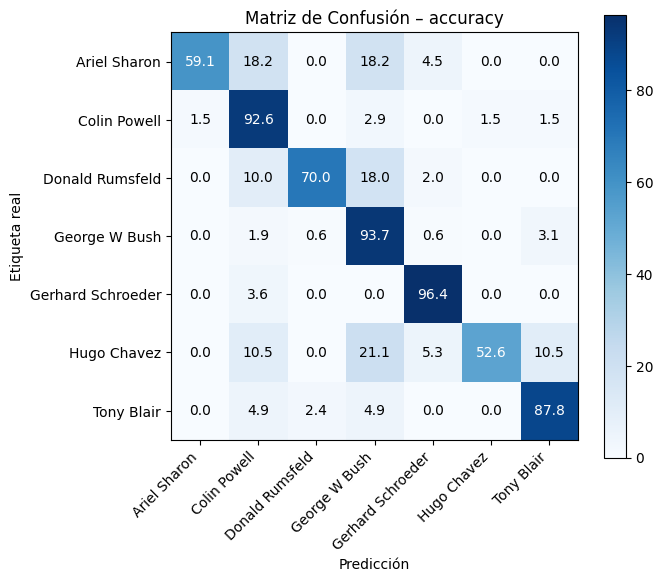

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.79      0.93      0.85        68
  Donald Rumsfeld       0.95      0.70      0.80        50
    George W Bush       0.88      0.94      0.91       159
Gerhard Schroeder       0.87      0.96      0.92        28
      Hugo Chavez       0.91      0.53      0.67        19
       Tony Blair       0.82      0.88      0.85        41

         accuracy                           0.86       387
        macro avg       0.88      0.79      0.82       387
     weighted avg       0.87      0.86      0.86       387



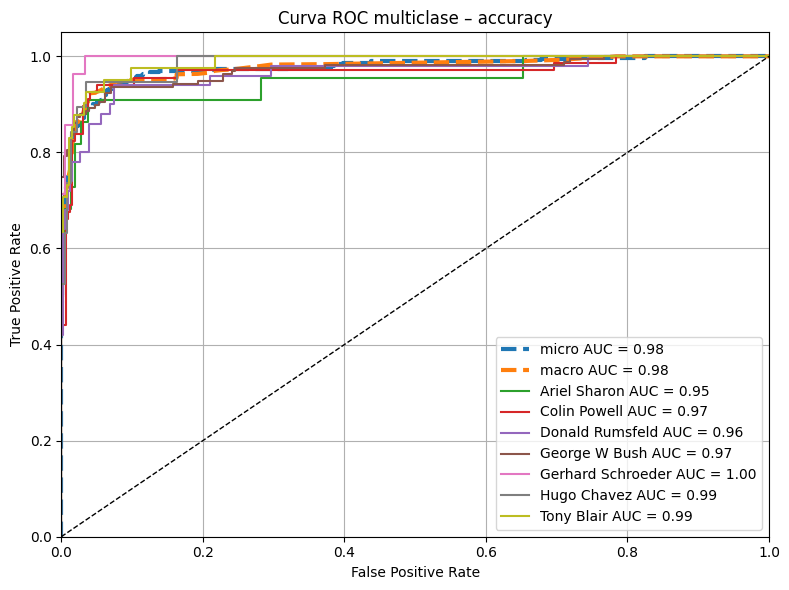


📊 Evaluación para modelo optimizado por: f1_macro


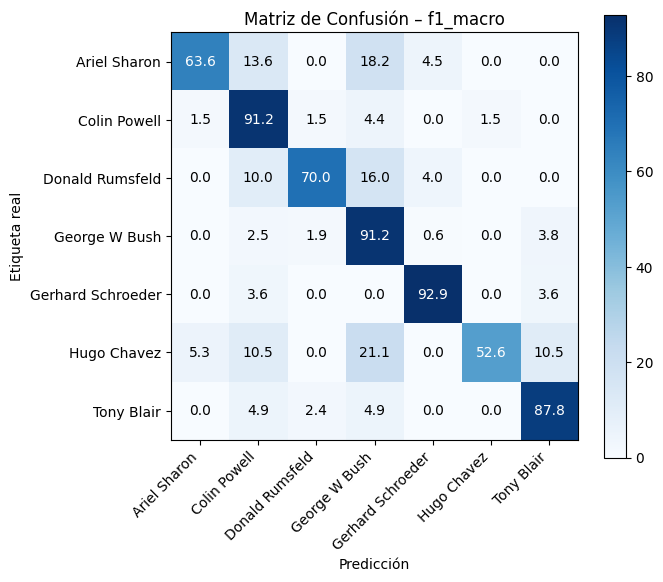

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.64      0.74        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.88      0.70      0.78        50
    George W Bush       0.87      0.91      0.89       159
Gerhard Schroeder       0.87      0.93      0.90        28
      Hugo Chavez       0.91      0.53      0.67        19
       Tony Blair       0.80      0.88      0.84        41

         accuracy                           0.85       387
        macro avg       0.85      0.78      0.81       387
     weighted avg       0.85      0.85      0.84       387



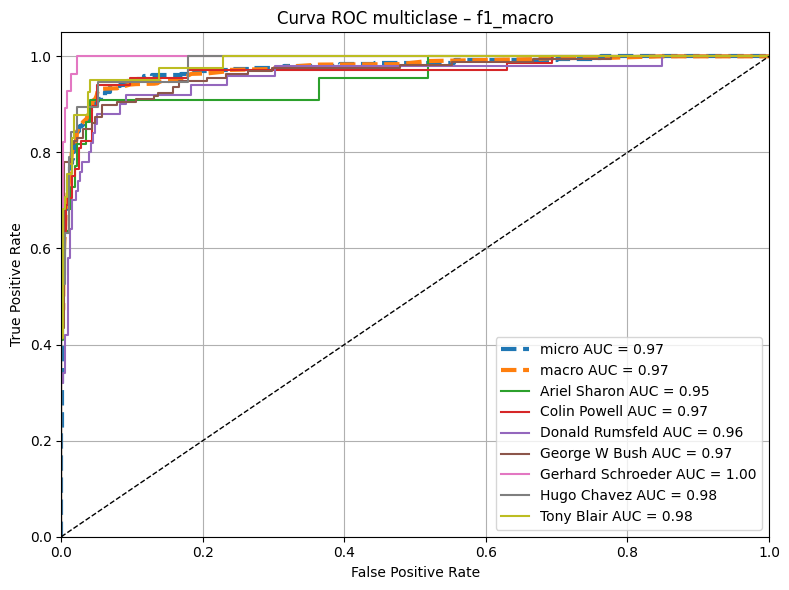


📊 Evaluación para modelo optimizado por: roc_auc_ovr


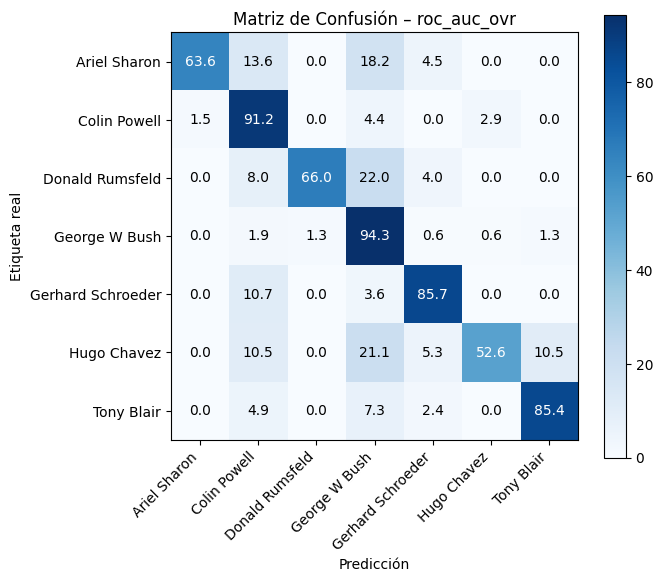

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.94      0.66      0.78        50
    George W Bush       0.85      0.94      0.90       159
Gerhard Schroeder       0.80      0.86      0.83        28
      Hugo Chavez       0.77      0.53      0.62        19
       Tony Blair       0.90      0.85      0.88        41

         accuracy                           0.85       387
        macro avg       0.85      0.77      0.80       387
     weighted avg       0.85      0.85      0.84       387



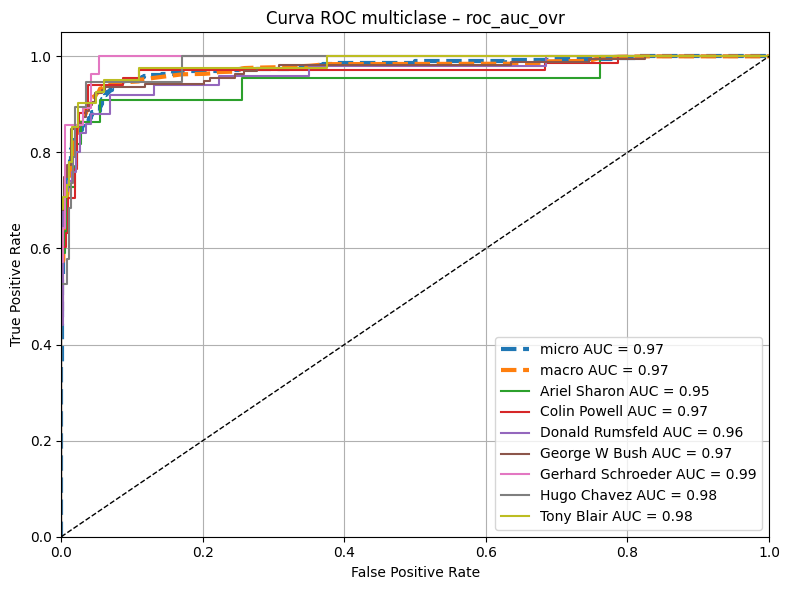

In [ ]:
# ================================================
#  LOGISTIC REGRESSION  – Optuna + CV5 + ROC plots
# ================================================

# --- IMPORTACIONES BÁSICAS ---
import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.utils.multiclass import unique_labels

# --- VALIDACIÓN CRUZADA ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- FUNCIÓN OBJETIVO PARA OPTUNA ---
def objective(trial, X, y, scoring):
    solver  = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    penalty = "l2" if solver == "lbfgs" else trial.suggest_categorical("penalty", ["l1", "l2"])
    C       = trial.suggest_float("C", 1e-2, 1e2, log=True)

    model = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier",
         LogisticRegression(solver=solver, penalty=penalty, C=C,
                            max_iter=1500, multi_class="ovr",
                            n_jobs=-1, random_state=42))
    ])

    return cross_val_score(model, X, y,
                           cv=cv, scoring=scoring,
                           n_jobs=-1).mean()

# --- OPTIMIZACIÓN ---
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
resultados_log = {}

for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=20, timeout=240)

    if study.best_trial.state.name == "COMPLETE":
        resultados_log[metric] = {"score": study.best_value,
                                  "params": study.best_params}
    else:
        print(f"⚠️ Sin resultados válidos en: {metric}")

# --- EVALUACIÓN EN TEST ---
target_names = lfw_people.target_names
ytest_bin    = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_log.items():
    print(f"\n📊 Evaluación para modelo optimizado por: {metric}")
    p = info["params"]

    modelo = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier",
         LogisticRegression(solver=p["solver"],
                            penalty=p.get("penalty", "l2"),
                            C=p["C"],
                            max_iter=1500, multi_class="ovr",
                            n_jobs=-1, random_state=42))
    ]).fit(Xtrain, ytrain)

    # ---------- Predicciones ----------
    y_pred  = modelo.predict(Xtest)
    y_score = modelo.predict_proba(Xtest)

    # ---------- Matriz de confusión ----------
    cm = confusion_matrix(ytest, y_pred, normalize="true") * 100
    lbl = target_names[unique_labels(ytest, y_pred)]

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lbl)), yticks=np.arange(len(lbl)),
           xticklabels=lbl, yticklabels=lbl,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"Matriz de Confusión – {metric}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    # ---------- Reporte ----------
    print(classification_report(ytest, y_pred, target_names=target_names))

    # ---------- Curvas ROC multiclase ----------
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-promedio
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-promedio (cálculo corregido)
    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0, 1]); plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC multiclase – {metric}")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()


Linear Discriminant Analysis

[I 2025-06-02 22:56:28,191] A new study created in memory with name: no-name-48dcbe9a-86df-4b50-8f0d-a7f0f1e586f8



🔍 Optimizando para: accuracy


[I 2025-06-02 22:56:46,954] Trial 0 finished with value: 0.8157458563535911 and parameters: {'solver': 'eigen', 'shrink_type': 'auto'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:56:49,606] Trial 1 finished with value: 0.7102946593001842 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:56:52,473] Trial 2 finished with value: 0.7102946593001842 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:56:54,606] Trial 3 finished with value: 0.7102946593001842 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:56:56,734] Trial 4 finished with value: 0.7102946593001842 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:56:58,864] Trial 5 finished with value: 0.7102946593001842 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8157458563535911.
[I 2025-06-02 22:57:1


🔍 Optimizando para: f1_macro


[I 2025-06-02 23:00:56,700] Trial 0 finished with value: 0.7805363723550868 and parameters: {'solver': 'eigen', 'shrink_type': 'auto'}. Best is trial 0 with value: 0.7805363723550868.
[I 2025-06-02 23:01:15,201] Trial 1 finished with value: 0.6031909031599878 and parameters: {'solver': 'lsqr', 'shrink_type': 'float', 'shrink_float': 0.00016275146987602404}. Best is trial 0 with value: 0.7805363723550868.
[I 2025-06-02 23:01:31,870] Trial 2 finished with value: 0.7805363723550868 and parameters: {'solver': 'eigen', 'shrink_type': 'auto'}. Best is trial 0 with value: 0.7805363723550868.
[I 2025-06-02 23:01:48,482] Trial 3 finished with value: 0.7805363723550868 and parameters: {'solver': 'eigen', 'shrink_type': 'auto'}. Best is trial 0 with value: 0.7805363723550868.
[I 2025-06-02 23:02:03,076] Trial 4 finished with value: 0.6150776564868488 and parameters: {'solver': 'eigen', 'shrink_type': 'float', 'shrink_float': 0.0011560310532710077}. Best is trial 0 with value: 0.7805363723550868.



🔍 Optimizando para: roc_auc_ovr


[I 2025-06-02 23:04:49,978] Trial 0 finished with value: 0.907353864286789 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.907353864286789.
[I 2025-06-02 23:04:52,107] Trial 1 finished with value: 0.907353864286789 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.907353864286789.
[I 2025-06-02 23:04:55,128] Trial 2 finished with value: 0.907353864286789 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.907353864286789.
[I 2025-06-02 23:05:12,081] Trial 3 finished with value: 0.9480708943658304 and parameters: {'solver': 'eigen', 'shrink_type': 'auto'}. Best is trial 3 with value: 0.9480708943658304.
[I 2025-06-02 23:05:32,620] Trial 4 finished with value: 0.9480708943658304 and parameters: {'solver': 'lsqr', 'shrink_type': 'auto'}. Best is trial 3 with value: 0.9480708943658304.
[I 2025-06-02 23:05:47,150] Trial 5 finished with value: 0.893846377956323 and parameters: {'solver': 'eigen', 'shrink_type': 'float', 'shrink_float': 0.003944730


📊 Evaluación para modelo optimizado por: accuracy


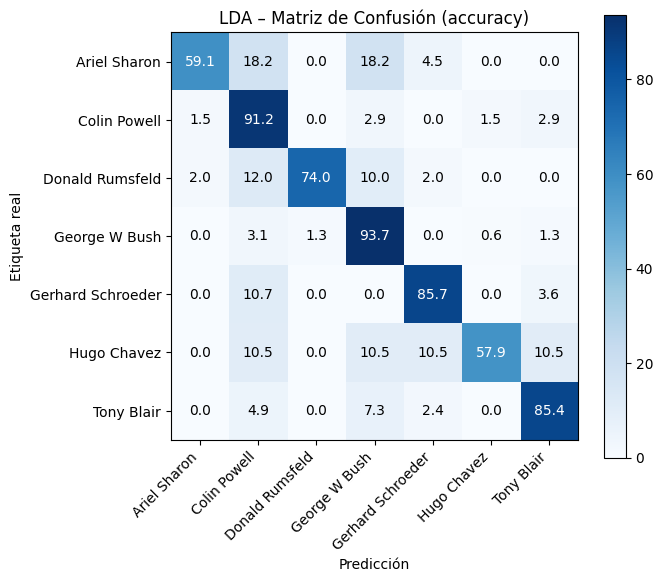

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.59      0.70        22
     Colin Powell       0.74      0.91      0.82        68
  Donald Rumsfeld       0.95      0.74      0.83        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.83      0.86      0.84        28
      Hugo Chavez       0.85      0.58      0.69        19
       Tony Blair       0.83      0.85      0.84        41

         accuracy                           0.86       387
        macro avg       0.85      0.78      0.81       387
     weighted avg       0.86      0.86      0.85       387



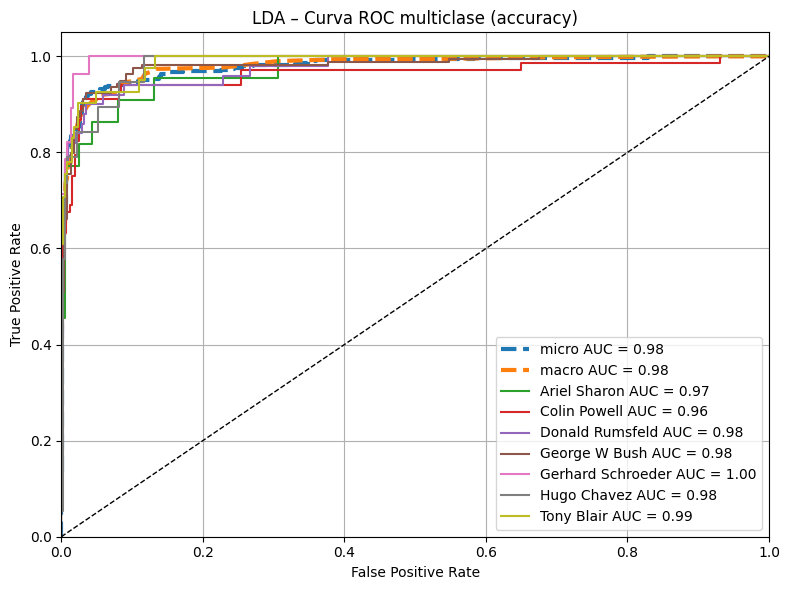


📊 Evaluación para modelo optimizado por: f1_macro


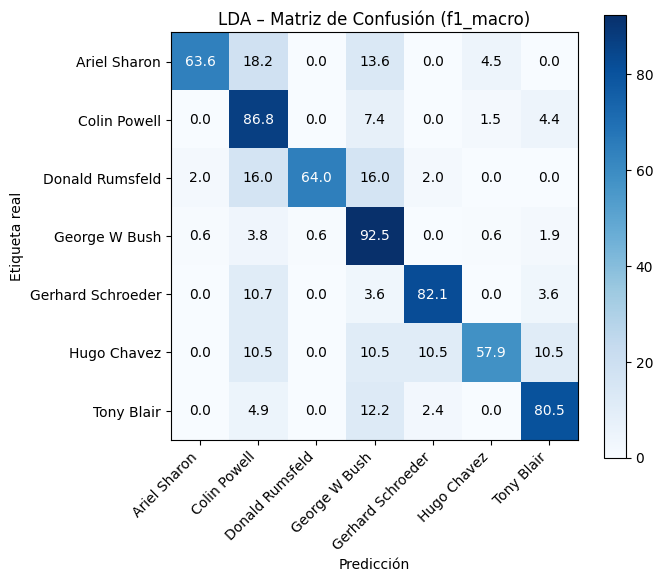

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.64      0.74        22
     Colin Powell       0.70      0.87      0.78        68
  Donald Rumsfeld       0.97      0.64      0.77        50
    George W Bush       0.86      0.92      0.89       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.79      0.58      0.67        19
       Tony Blair       0.79      0.80      0.80        41

         accuracy                           0.82       387
        macro avg       0.83      0.75      0.78       387
     weighted avg       0.84      0.82      0.82       387



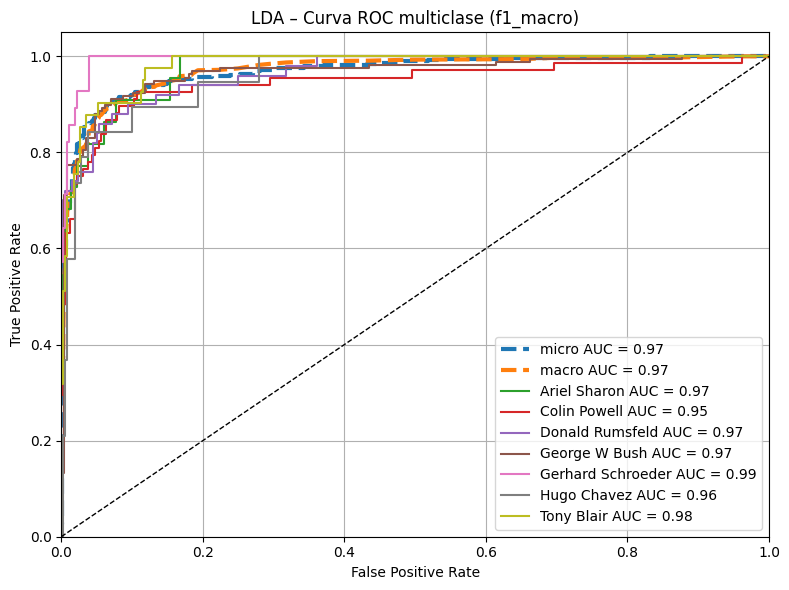


📊 Evaluación para modelo optimizado por: roc_auc_ovr


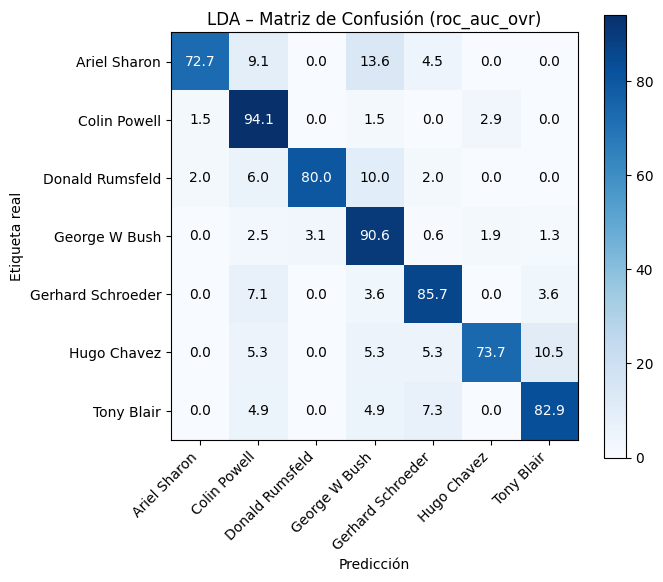

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        22
     Colin Powell       0.82      0.94      0.88        68
  Donald Rumsfeld       0.89      0.80      0.84        50
    George W Bush       0.92      0.91      0.91       159
Gerhard Schroeder       0.77      0.86      0.81        28
      Hugo Chavez       0.74      0.74      0.74        19
       Tony Blair       0.87      0.83      0.85        41

         accuracy                           0.87       387
        macro avg       0.84      0.83      0.83       387
     weighted avg       0.87      0.87      0.87       387



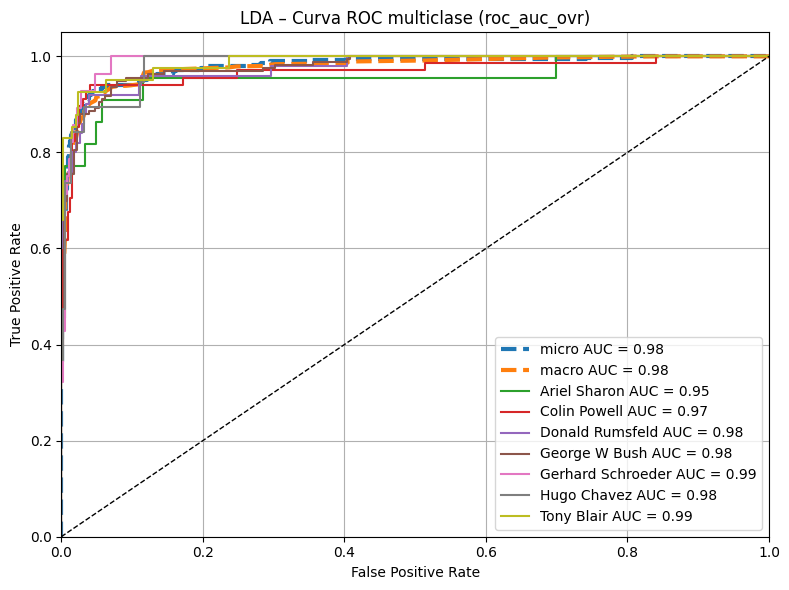

In [ ]:
# ====================================================
#  LINEAR DISCRIMINANT ANALYSIS  –  versión sin fallos
# ====================================================

import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.utils.multiclass import unique_labels

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial, X, y, scoring):
    solver = trial.suggest_categorical("solver", ["svd", "lsqr", "eigen"])

    if solver == "svd":                   # svd IGNORA shrinkage
        lda_params = {"solver": "svd"}
    else:                                 # lsqr / eigen REQUIEREN shrinkage
        shrink_type = trial.suggest_categorical(
            "shrink_type", ["auto", "float"])
        shrink = "auto" if shrink_type == "auto" else trial.suggest_float(
            "shrink_float", 1e-4, 1.0, log=True)
        lda_params = {"solver": solver, "shrinkage": shrink}

    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", LDA(**lda_params))
    ])

    return cross_val_score(
        pipe, X, y, cv=cv, scoring=scoring,
        n_jobs=-1, error_score=np.nan      # si falla ⇒ NaN ⇒ trial podado
    ).mean()

# ---------- OPTIMIZACIÓN ----------
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
resultados_lda = {}
for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=20, timeout=240)
    if study.best_trial.state.name == "COMPLETE":
        resultados_lda[metric] = {"score": study.best_value,
                                  "params": study.best_params}

# ---------- EVALUACIÓN EN TEST ----------
target_names = lfw_people.target_names
ytest_bin = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_lda.items():
    print(f"\n📊 Evaluación para modelo optimizado por: {metric}")
    p = info["params"]

    # reconstruir LDA con los hiperparámetros óptimos
    solver = p["solver"]
    if solver == "svd":
        lda = LDA(solver="svd")
    else:
        shrink = p["shrinkage"] if "shrinkage" in p else (
            "auto" if p["shrink_type"] == "auto" else p["shrink_float"])
        lda = LDA(solver=solver, shrinkage=shrink)

    modelo = Pipeline([("scaler", MinMaxScaler()), ("classifier", lda)])
    modelo.fit(Xtrain, ytrain)

    # ------- Predicción y métricas -------
    y_pred  = modelo.predict(Xtest)
    y_score = modelo.predict_proba(Xtest)

    # Matriz de confusión
    cm = 100*confusion_matrix(ytest, y_pred, normalize="true")
    labels = target_names[unique_labels(ytest, y_pred)]
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"LDA – Matriz de Confusión ({metric})")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    print(classification_report(ytest, y_pred, target_names=target_names))

    # Curvas ROC multiclase (micro / macro / por clase)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"LDA – Curva ROC multiclase ({metric})")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()


KNeighborsClassifier

[I 2025-06-03 00:46:47,690] A new study created in memory with name: no-name-abc454fc-a875-42a0-8472-9bf044405993



🔍 Optimizando para: accuracy


[I 2025-06-03 00:46:50,397] Trial 0 finished with value: 0.5560896255371393 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1, 'leaf_size': 29}. Best is trial 0 with value: 0.5560896255371393.
[I 2025-06-03 00:47:20,778] Trial 1 finished with value: 0.5083364027010436 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 3, 'leaf_size': 46}. Best is trial 0 with value: 0.5560896255371393.
[I 2025-06-03 00:47:22,477] Trial 2 finished with value: 0.5516144874155924 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1, 'leaf_size': 45}. Best is trial 0 with value: 0.5560896255371393.
[I 2025-06-03 00:47:23,123] Trial 3 finished with value: 0.523855125844076 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 2, 'leaf_size': 42}. Best is trial 0 with value: 0.5560896255371393.
[I 2025-06-03 00:47:53,687] Trial 4 finished with value: 0.5105402087170042 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 3, 'leaf_size': 31}. Best i


🔍 Optimizando para: f1_macro


[I 2025-06-03 00:49:02,649] Trial 0 finished with value: 0.21128585467599986 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2, 'leaf_size': 29}. Best is trial 0 with value: 0.21128585467599986.
[I 2025-06-03 00:49:03,084] Trial 1 finished with value: 0.27723236241011384 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2, 'leaf_size': 50}. Best is trial 1 with value: 0.27723236241011384.
[I 2025-06-03 00:49:32,155] Trial 2 finished with value: 0.28223384947098457 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 3, 'leaf_size': 36}. Best is trial 2 with value: 0.28223384947098457.
[I 2025-06-03 00:49:33,651] Trial 3 finished with value: 0.2751483746395652 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1, 'leaf_size': 43}. Best is trial 2 with value: 0.28223384947098457.
[I 2025-06-03 00:49:35,379] Trial 4 finished with value: 0.38385451466019466 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1, 'leaf_size': 60}.


🔍 Optimizando para: roc_auc_ovr


[I 2025-06-03 00:51:13,196] Trial 0 finished with value: 0.813480895850964 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'p': 2, 'leaf_size': 54}. Best is trial 0 with value: 0.813480895850964.
[I 2025-06-03 00:51:14,692] Trial 1 finished with value: 0.8328692420533281 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1, 'leaf_size': 43}. Best is trial 1 with value: 0.8328692420533281.
[I 2025-06-03 00:51:43,810] Trial 2 finished with value: 0.796945084152657 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'p': 3, 'leaf_size': 17}. Best is trial 1 with value: 0.8328692420533281.
[I 2025-06-03 00:51:44,237] Trial 3 finished with value: 0.8201508315672529 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2, 'leaf_size': 54}. Best is trial 1 with value: 0.8328692420533281.
[I 2025-06-03 00:51:45,730] Trial 4 finished with value: 0.8205703181226088 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 1, 'leaf_size': 40}. Best is tri


📊 Evaluación para modelo optimizado por: accuracy


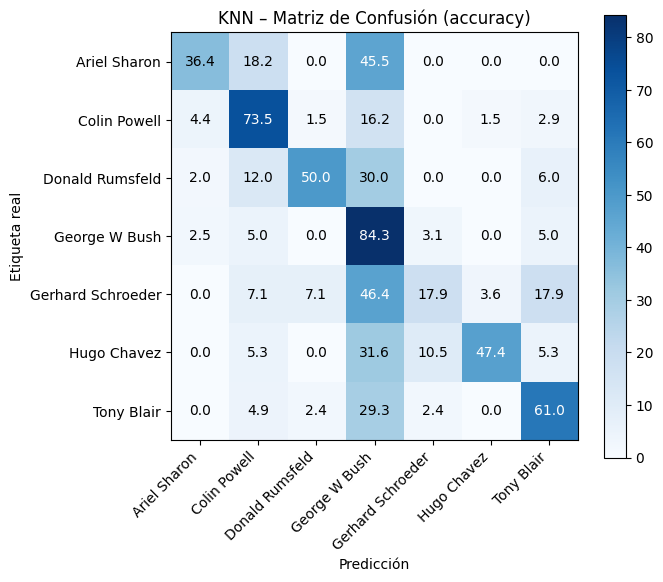

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.36      0.42        22
     Colin Powell       0.68      0.74      0.71        68
  Donald Rumsfeld       0.86      0.50      0.63        50
    George W Bush       0.67      0.84      0.74       159
Gerhard Schroeder       0.38      0.18      0.24        28
      Hugo Chavez       0.82      0.47      0.60        19
       Tony Blair       0.57      0.61      0.59        41

         accuracy                           0.66       387
        macro avg       0.64      0.53      0.56       387
     weighted avg       0.66      0.66      0.65       387



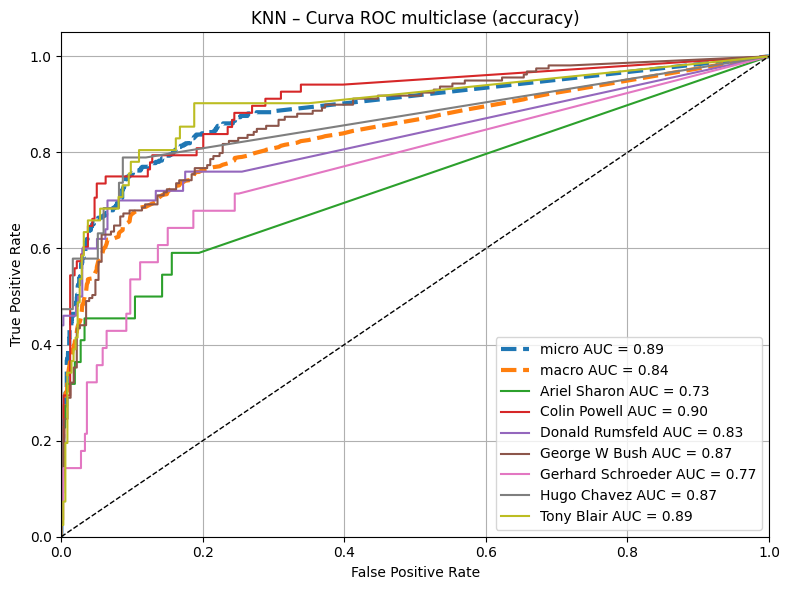


📊 Evaluación para modelo optimizado por: f1_macro


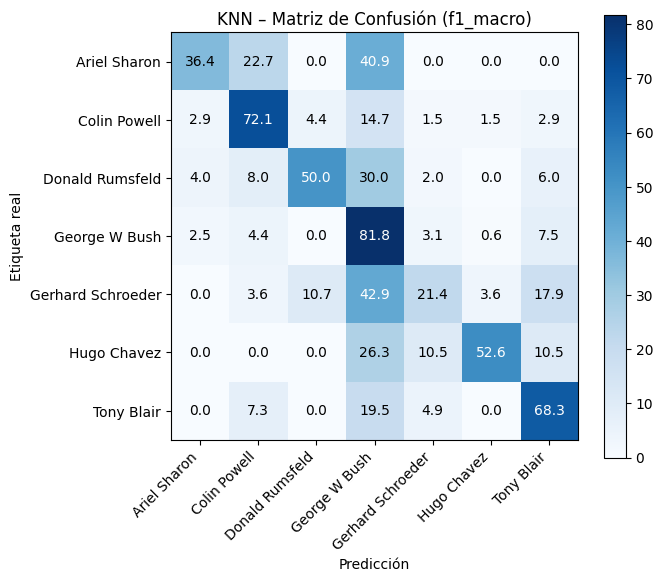

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.36      0.42        22
     Colin Powell       0.71      0.72      0.72        68
  Donald Rumsfeld       0.81      0.50      0.62        50
    George W Bush       0.69      0.82      0.75       159
Gerhard Schroeder       0.35      0.21      0.27        28
      Hugo Chavez       0.77      0.53      0.62        19
       Tony Blair       0.54      0.68      0.60        41

         accuracy                           0.66       387
        macro avg       0.62      0.55      0.57       387
     weighted avg       0.66      0.66      0.65       387



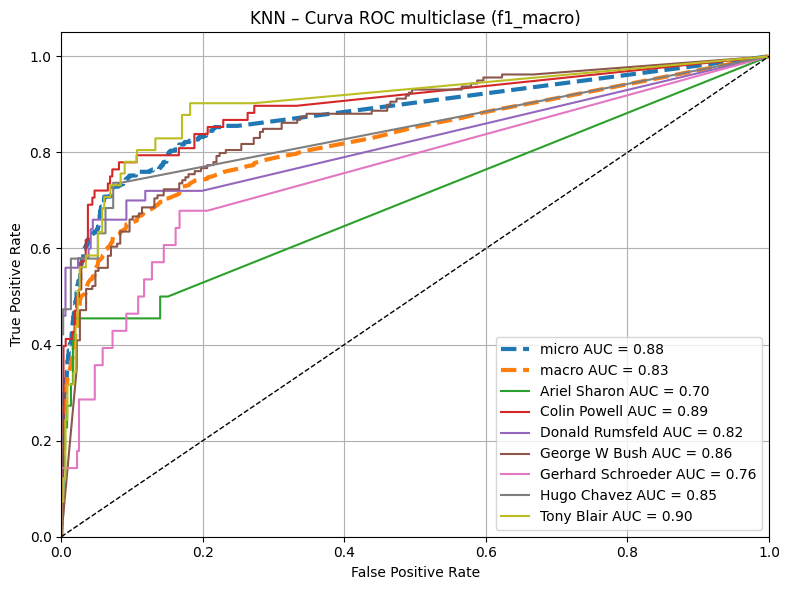


📊 Evaluación para modelo optimizado por: roc_auc_ovr


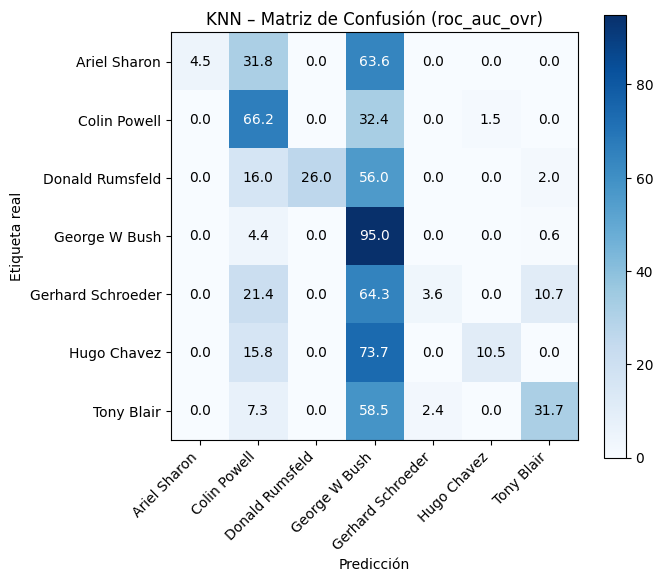

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       1.00      0.26      0.41        50
    George W Bush       0.56      0.95      0.70       159
Gerhard Schroeder       0.50      0.04      0.07        28
      Hugo Chavez       0.67      0.11      0.18        19
       Tony Blair       0.72      0.32      0.44        41

         accuracy                           0.58       387
        macro avg       0.72      0.34      0.36       387
     weighted avg       0.66      0.58      0.51       387



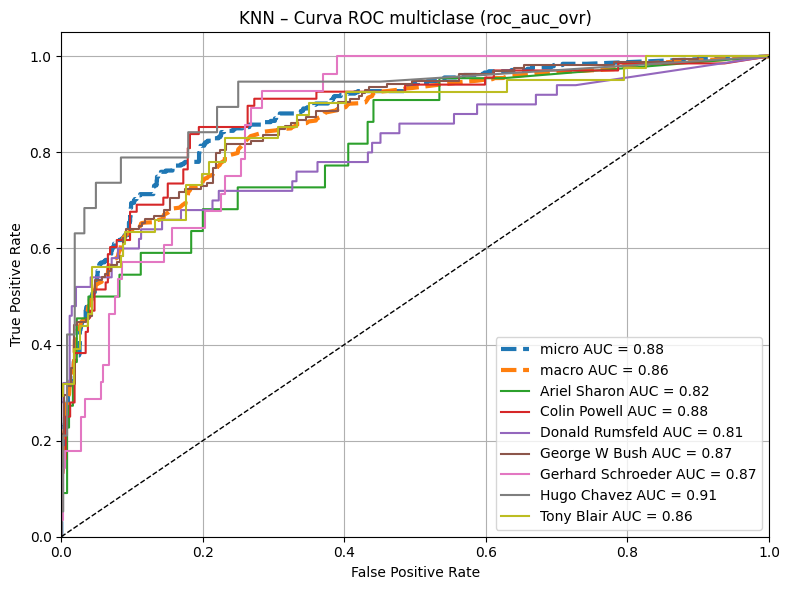

In [ ]:
# ==============================================================
#      KNN – Búsqueda ampliada (35 trials) con Optuna + CV5
# ==============================================================

# --- IMPORTACIONES ---
import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.utils.multiclass import unique_labels

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial, X, y, scoring):
    params = dict(
        n_neighbors = trial.suggest_int("n_neighbors", 1, 40),
        weights     = trial.suggest_categorical("weights", ["uniform", "distance"]),
        p           = trial.suggest_int("p", 1, 3),
        leaf_size   = trial.suggest_int("leaf_size", 15, 60),
        n_jobs      = -1                   # paralelismo dentro del modelo
    )
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", KNeighborsClassifier(**params))
    ])
    return cross_val_score(
        pipe, X, y, cv=cv, scoring=scoring,
        n_jobs=-1, error_score=np.nan      # si falla un fold ⇒ NaN
    ).mean()

# --- OPTIMIZACIÓN ---
pruner = optuna.pruners.MedianPruner(n_startup_trials=8, n_warmup_steps=1)
resultados_knn = {}

for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=35, timeout=480)     # máx 8 min; aborta si excede
    if study.best_trial.state.name == "COMPLETE":
        resultados_knn[metric] = {"score": study.best_value,
                                  "params": study.best_params}
    else:
        print(f"⚠️ Sin resultados válidos en: {metric}")

# --- EVALUACIÓN EN TEST ---
target_names = lfw_people.target_names
ytest_bin    = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_knn.items():
    print(f"\n📊 Evaluación para modelo optimizado por: {metric}")
    p = info["params"]
    modelo = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", KNeighborsClassifier(**p))
    ]).fit(Xtrain, ytrain)

    y_pred  = modelo.predict(Xtest)
    y_score = modelo.predict_proba(Xtest)

    # ---------- Matriz de confusión ----------
    cm = 100 * confusion_matrix(ytest, y_pred, normalize="true")
    lbls = target_names[unique_labels(ytest, y_pred)]
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lbls)), yticks=np.arange(len(lbls)),
           xticklabels=lbls, yticklabels=lbls,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"KNN – Matriz de Confusión ({metric})")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    # ---------- Reporte ----------
    print(classification_report(ytest, y_pred, target_names=target_names))

    # ---------- Curvas ROC ----------
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0, 1]); plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"KNN – Curva ROC multiclase ({metric})")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()


LinearSVC

[I 2025-06-03 01:50:42,730] A new study created in memory with name: no-name-25f8668a-74d2-44f0-a12c-378f191b026d



🔍 Optimizando para: accuracy


[I 2025-06-03 01:51:09,530] Trial 0 finished with value: 0.8079864947820748 and parameters: {'variant': 'sqhinge_primal', 'C': 6.197596175281719}. Best is trial 0 with value: 0.8079864947820748.
[I 2025-06-03 01:52:29,855] Trial 1 finished with value: 0.7979926335174954 and parameters: {'variant': 'hinge_dual', 'C': 0.9853205660936122}. Best is trial 0 with value: 0.8079864947820748.
[I 2025-06-03 01:52:45,587] Trial 2 finished with value: 0.8057765500306937 and parameters: {'variant': 'sqhinge_primal', 'C': 1.2629952422433612}. Best is trial 0 with value: 0.8079864947820748.
[I 2025-06-03 01:52:53,305] Trial 3 finished with value: 0.8013259668508287 and parameters: {'variant': 'sqhinge_primal', 'C': 743.7548885902653}. Best is trial 0 with value: 0.8079864947820748.
[I 2025-06-03 01:52:59,489] Trial 4 finished with value: 0.82353591160221 and parameters: {'variant': 'sqhinge_primal', 'C': 0.08583841297253988}. Best is trial 4 with value: 0.82353591160221.
[I 2025-06-03 01:54:17,296] T


🔍 Optimizando para: f1_macro


[I 2025-06-03 01:58:18,796] Trial 0 finished with value: 0.7480737866528466 and parameters: {'variant': 'hinge_dual', 'C': 23.085297825651107}. Best is trial 0 with value: 0.7480737866528466.
[I 2025-06-03 01:58:24,342] Trial 1 finished with value: 0.42860195243026683 and parameters: {'variant': 'sqhinge_primal', 'C': 0.001424973921851522}. Best is trial 0 with value: 0.7480737866528466.
[I 2025-06-03 01:59:44,796] Trial 2 finished with value: 0.7475882442945733 and parameters: {'variant': 'hinge_dual', 'C': 0.7949660394053453}. Best is trial 0 with value: 0.7480737866528466.
[I 2025-06-03 02:01:06,052] Trial 3 finished with value: 0.7480737866528466 and parameters: {'variant': 'hinge_dual', 'C': 40.80245633228738}. Best is trial 0 with value: 0.7480737866528466.
[I 2025-06-03 02:01:24,568] Trial 4 finished with value: 0.7576804784292872 and parameters: {'variant': 'sqhinge_primal', 'C': 1.7823492743988718}. Best is trial 4 with value: 0.7576804784292872.
[I 2025-06-03 02:01:38,037] Tr


🔍 Optimizando para: roc_auc_ovr


[W 2025-06-03 02:03:24,446] Trial 0 failed with parameters: {'variant': 'sqhinge_primal', 'C': 4.7526958284480925} because of the following error: The value nan is not acceptable.
[W 2025-06-03 02:03:24,447] Trial 0 failed with value np.float64(nan).
[W 2025-06-03 02:03:48,274] Trial 1 failed with parameters: {'variant': 'sqhinge_primal', 'C': 6.049243788109155} because of the following error: The value nan is not acceptable.
[W 2025-06-03 02:03:48,275] Trial 1 failed with value np.float64(nan).
[W 2025-06-03 02:03:53,981] Trial 2 failed with parameters: {'variant': 'sqhinge_primal', 'C': 0.013189386129020207} because of the following error: The value nan is not acceptable.
[W 2025-06-03 02:03:53,982] Trial 2 failed with value np.float64(nan).
[W 2025-06-03 02:04:00,259] Trial 3 failed with parameters: {'variant': 'sqhinge_primal', 'C': 0.006137325952058756} because of the following error: The value nan is not acceptable.
[W 2025-06-03 02:04:00,260] Trial 3 failed with value np.float64

⚠️ Ningún trial completo para roc_auc_ovr

📊 Evaluación (LinearSVC, optimizada por accuracy)


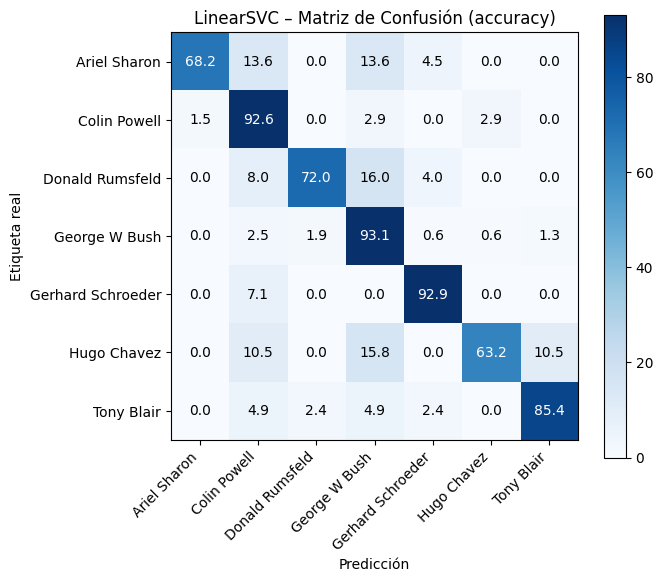

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.79      0.93      0.85        68
  Donald Rumsfeld       0.90      0.72      0.80        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.90      0.85      0.88        41

         accuracy                           0.87       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.87      0.86       387



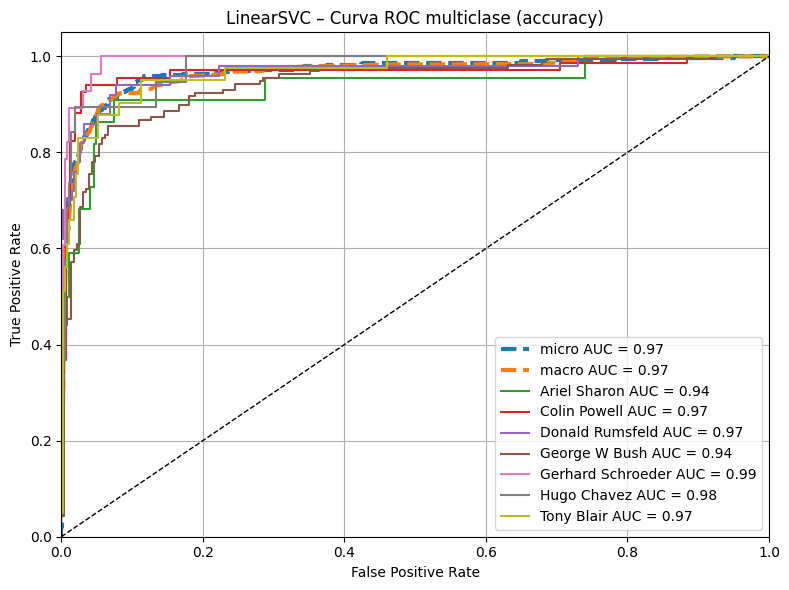


📊 Evaluación (LinearSVC, optimizada por f1_macro)


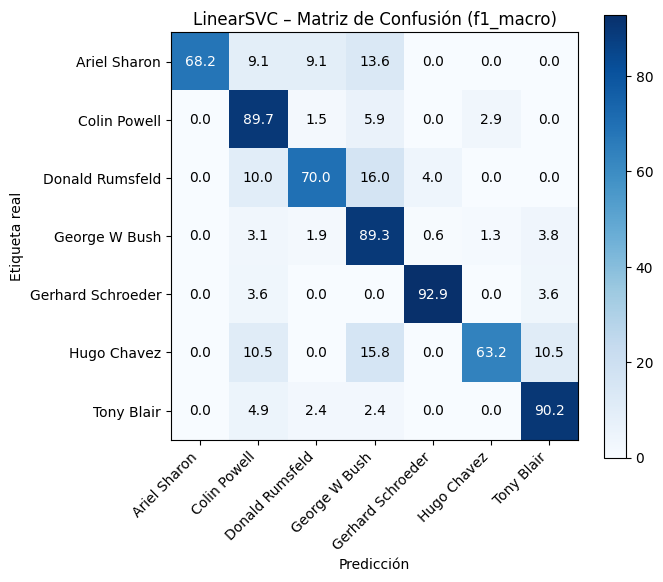

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.68      0.81        22
     Colin Powell       0.78      0.90      0.84        68
  Donald Rumsfeld       0.83      0.70      0.76        50
    George W Bush       0.88      0.89      0.89       159
Gerhard Schroeder       0.90      0.93      0.91        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.80      0.90      0.85        41

         accuracy                           0.85       387
        macro avg       0.85      0.80      0.82       387
     weighted avg       0.85      0.85      0.85       387



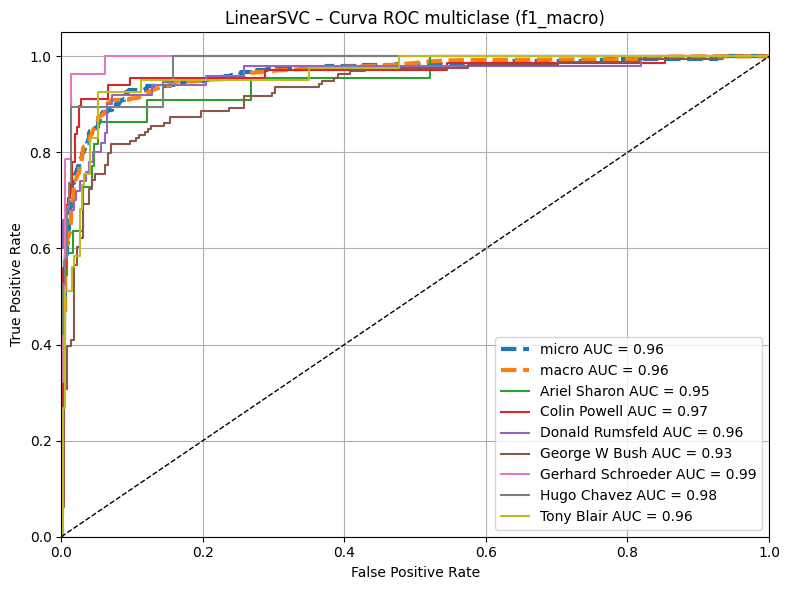

In [ ]:
# ===============================================================
#  LINEARSVC – búsqueda estable (solo combos válidos)
# ===============================================================

import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.utils.multiclass import unique_labels

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------- FUNCIÓN OBJETIVO ----------
def objective(trial, X, y, scoring):
    # Elegir una de las dos configuraciones legales
    variant = trial.suggest_categorical("variant", ["hinge_dual", "sqhinge_primal"])
    if variant == "hinge_dual":          # Variante A
        lsvc_params = dict(loss="hinge",  penalty="l2", dual=True)
    else:                                # Variante B
        lsvc_params = dict(loss="squared_hinge", penalty="l2", dual=False)

    lsvc_params["C"]         = trial.suggest_float("C", 1e-3, 1e3, log=True)
    lsvc_params["max_iter"]   = 3000
    lsvc_params["multi_class"] = "ovr"
    lsvc_params["random_state"] = 42

    model = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", LinearSVC(**lsvc_params))
    ])

    # Si algo explota (poco probable ahora) => NaN => trial podado
    try:
        score = cross_val_score(model, X, y,
                                cv=cv, scoring=scoring,
                                n_jobs=-1).mean()
    except Exception:
        raise optuna.exceptions.TrialPruned()

    return score

# ---------- OPTIMIZACIÓN ----------
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
resultados_lsvc = {}
for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=25, timeout=360)

    # ⇩⇩ ahora SIEMPRE hay algún trial completo
    best_trial = [t for t in study.trials if t.state.name == "COMPLETE"]
    if best_trial:
        bt = max(best_trial, key=lambda t: t.value)   # mayor score
        resultados_lsvc[metric] = {"score": bt.value,
                                   "params": bt.params}
    else:
        print(f"⚠️ Ningún trial completo para {metric}")

# ---------- EVALUACIÓN EN TEST ----------
target_names = lfw_people.target_names
ytest_bin    = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_lsvc.items():
    print(f"\n📊 Evaluación (LinearSVC, optimizada por {metric})")
    p = info["params"]

    # Reconstruir modelo ganador
    if p["variant"] == "hinge_dual":
        lsvc = LinearSVC(loss="hinge", penalty="l2", dual=True,
                         C=p["C"], max_iter=3000, multi_class="ovr",
                         random_state=42)
    else:
        lsvc = LinearSVC(loss="squared_hinge", penalty="l2", dual=False,
                         C=p["C"], max_iter=3000, multi_class="ovr",
                         random_state=42)

    modelo = Pipeline([("scaler", MinMaxScaler()), ("classifier", lsvc)])
    modelo.fit(Xtrain, ytrain)

    # ---------- Predicción ----------
    y_pred  = modelo.predict(Xtest)
    y_score = modelo.decision_function(Xtest)

    # ---------- Matriz de confusión ----------
    cm = 100*confusion_matrix(ytest, y_pred, normalize="true")
    lbl = target_names[unique_labels(ytest, y_pred)]
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lbl)), yticks=np.arange(len(lbl)),
           xticklabels=lbl, yticklabels=lbl,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"LinearSVC – Matriz de Confusión ({metric})")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    # ---------- Reporte ----------
    print(classification_report(ytest, y_pred, target_names=target_names))

    # ---------- Curvas ROC (micro, macro y por clase) ----------
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"LinearSVC – Curva ROC multiclase ({metric})")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()


SVM con kernel (SVC)

[I 2025-06-03 02:38:04,090] A new study created in memory with name: no-name-19c1e8c1-0288-4a38-a099-892c1c04a025



🔍 Optimizando para: accuracy


[I 2025-06-03 02:38:24,451] Trial 0 finished with value: 0.8001903007980354 and parameters: {'kernel': 'poly', 'C': 96.50599827842272, 'gamma': 0.0032881946366225276, 'degree': 2, 'coef0': 0.8647362082606334}. Best is trial 0 with value: 0.8001903007980354.
[I 2025-06-03 02:38:54,363] Trial 1 finished with value: 0.5704358502148558 and parameters: {'kernel': 'rbf', 'C': 1.8353282022260735, 'gamma': 0.05174598871869981}. Best is trial 0 with value: 0.8001903007980354.
[I 2025-06-03 02:39:13,833] Trial 2 finished with value: 0.8068692449355431 and parameters: {'kernel': 'rbf', 'C': 33.935347101226746, 'gamma': 0.010580636093405994}. Best is trial 2 with value: 0.8068692449355431.
[I 2025-06-03 02:39:24,896] Trial 3 finished with value: 0.7924248004910988 and parameters: {'kernel': 'poly', 'C': 111.56723287226355, 'gamma': 0.0002654680170554705, 'degree': 2, 'coef0': 0.4627999044468575}. Best is trial 2 with value: 0.8068692449355431.
[I 2025-06-03 02:39:41,186] Trial 4 finished with valu


🔍 Optimizando para: f1_macro


[I 2025-06-03 02:45:18,611] Trial 0 finished with value: 0.7541095814580778 and parameters: {'kernel': 'poly', 'C': 62.84713724643824, 'gamma': 0.004544022007671447, 'degree': 3, 'coef0': 0.6895385900177958}. Best is trial 0 with value: 0.7541095814580778.
[I 2025-06-03 02:45:33,640] Trial 1 finished with value: 0.585151204440494 and parameters: {'kernel': 'rbf', 'C': 4.638427457895652, 'gamma': 0.001428442837769163}. Best is trial 0 with value: 0.7541095814580778.
[I 2025-06-03 02:45:46,117] Trial 2 finished with value: 0.7608528520734505 and parameters: {'kernel': 'rbf', 'C': 837.4582770781678, 'gamma': 0.000738182919008026}. Best is trial 2 with value: 0.7608528520734505.
[I 2025-06-03 02:45:59,858] Trial 3 finished with value: 0.08333311277266812 and parameters: {'kernel': 'poly', 'C': 0.3820976847979474, 'gamma': 0.00044545239187831934, 'degree': 2, 'coef0': 0.8697190532629374}. Best is trial 2 with value: 0.7608528520734505.
[I 2025-06-03 02:46:13,462] Trial 4 finished with value


🔍 Optimizando para: roc_auc_ovr


[I 2025-06-03 02:51:38,584] Trial 0 finished with value: 0.956416300458099 and parameters: {'kernel': 'poly', 'C': 9.623883728468918, 'gamma': 0.0023156131350186957, 'degree': 2, 'coef0': 0.259834892071347}. Best is trial 0 with value: 0.956416300458099.
[I 2025-06-03 02:51:55,003] Trial 1 finished with value: 0.919335207858737 and parameters: {'kernel': 'rbf', 'C': 0.25447291072738076, 'gamma': 0.0006049315174107915}. Best is trial 0 with value: 0.956416300458099.
[I 2025-06-03 02:52:05,200] Trial 2 finished with value: 0.9548930490729151 and parameters: {'kernel': 'poly', 'C': 416.7681336483607, 'gamma': 0.0694431704141476, 'degree': 2, 'coef0': 0.33797627765367}. Best is trial 0 with value: 0.956416300458099.
[I 2025-06-03 02:52:21,648] Trial 3 finished with value: 0.9189065583785869 and parameters: {'kernel': 'rbf', 'C': 2.758059980787117, 'gamma': 0.0001678757493520566}. Best is trial 0 with value: 0.956416300458099.
[I 2025-06-03 02:52:30,704] Trial 4 finished with value: 0.94025


📊 Evaluación (SVC optimizado por accuracy)


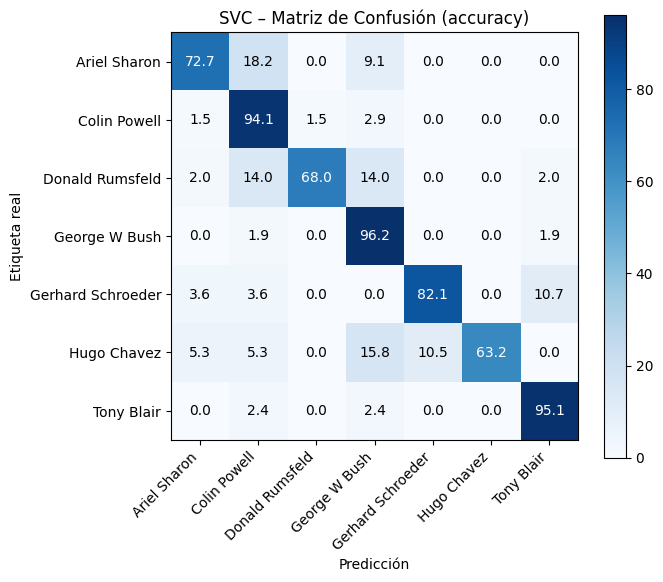

                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.73      0.76        22
     Colin Powell       0.79      0.94      0.86        68
  Donald Rumsfeld       0.97      0.68      0.80        50
    George W Bush       0.91      0.96      0.94       159
Gerhard Schroeder       0.92      0.82      0.87        28
      Hugo Chavez       1.00      0.63      0.77        19
       Tony Blair       0.85      0.95      0.90        41

         accuracy                           0.88       387
        macro avg       0.89      0.82      0.84       387
     weighted avg       0.89      0.88      0.88       387



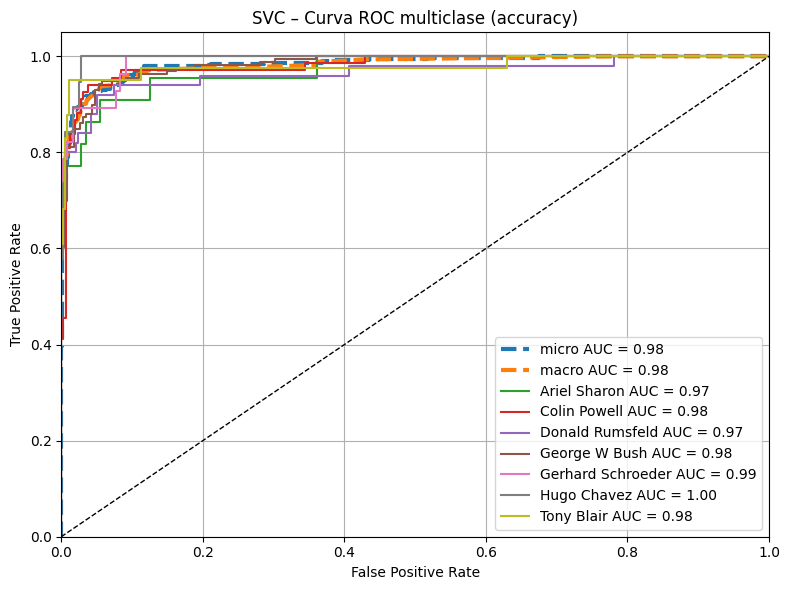


📊 Evaluación (SVC optimizado por f1_macro)


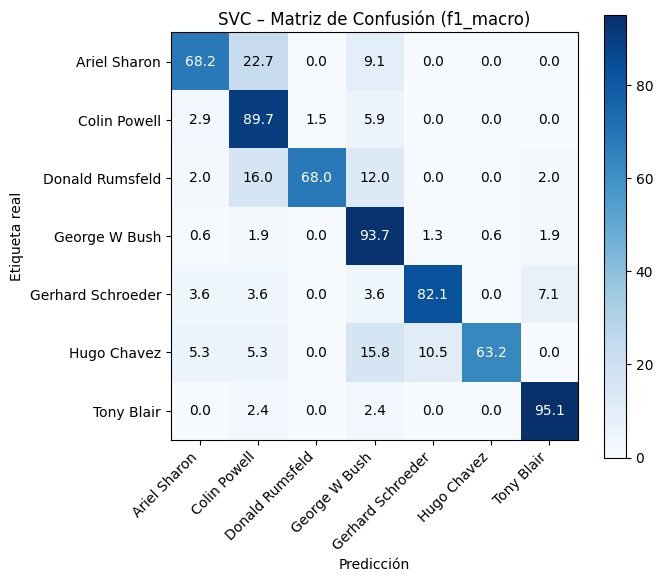

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.68      0.70        22
     Colin Powell       0.76      0.90      0.82        68
  Donald Rumsfeld       0.97      0.68      0.80        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.87      0.95      0.91        41

         accuracy                           0.86       387
        macro avg       0.86      0.80      0.82       387
     weighted avg       0.87      0.86      0.86       387



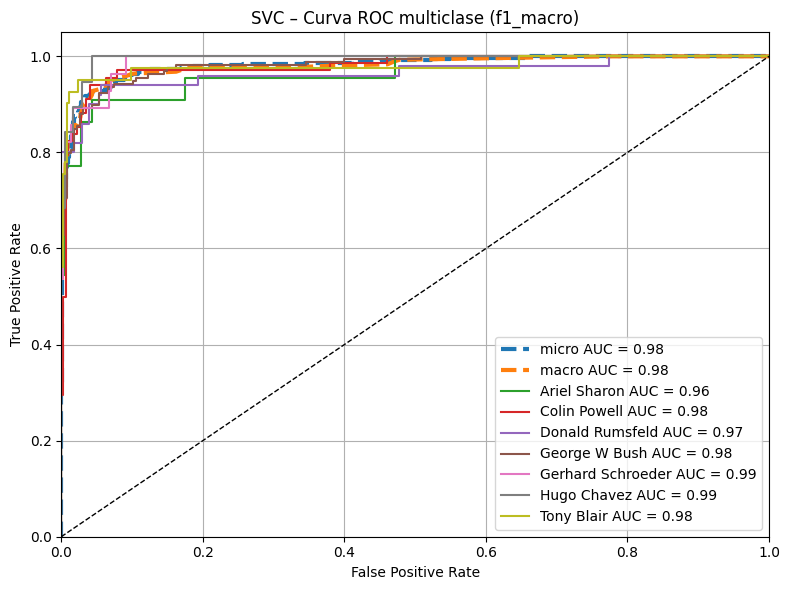


📊 Evaluación (SVC optimizado por roc_auc_ovr)


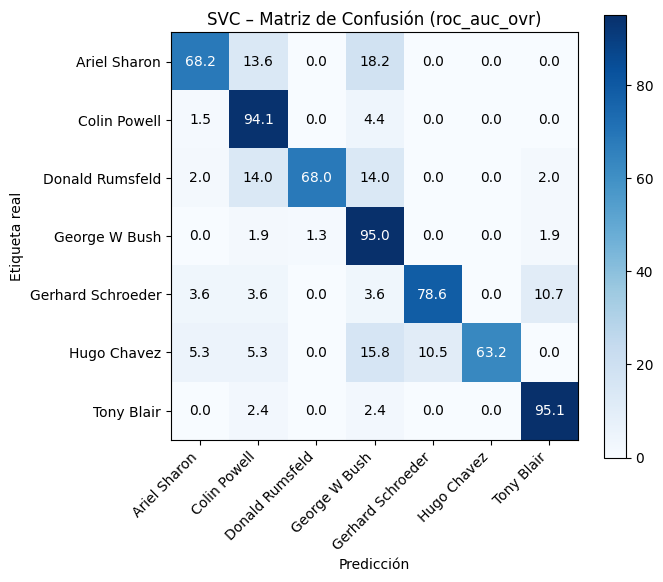

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.68      0.73        22
     Colin Powell       0.80      0.94      0.86        68
  Donald Rumsfeld       0.94      0.68      0.79        50
    George W Bush       0.89      0.95      0.92       159
Gerhard Schroeder       0.92      0.79      0.85        28
      Hugo Chavez       1.00      0.63      0.77        19
       Tony Blair       0.85      0.95      0.90        41

         accuracy                           0.87       387
        macro avg       0.88      0.80      0.83       387
     weighted avg       0.88      0.87      0.87       387



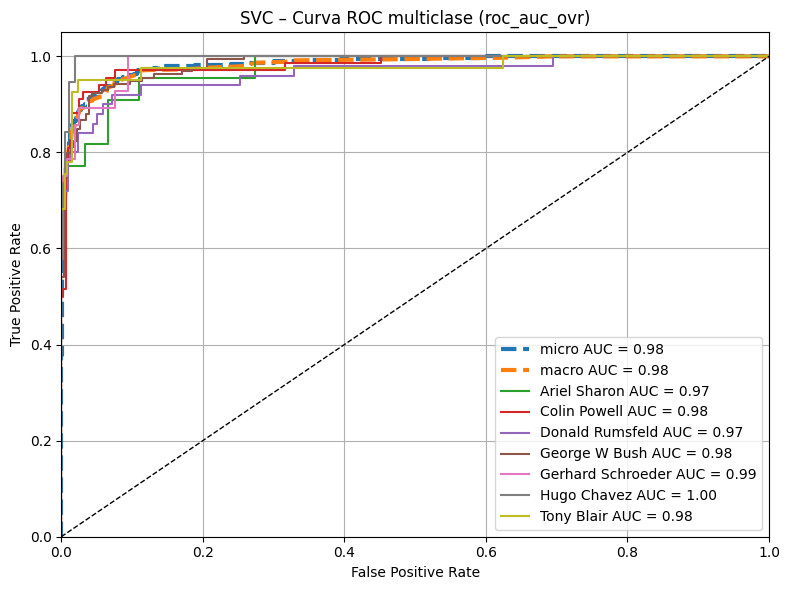

In [ ]:
# ================================================================
#  SVC (kernel no lineal) – Optuna + CV-5 + Métricas + ROC
# ================================================================

# --- IMPORTACIONES ---
import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.utils.multiclass import unique_labels

# --- VALIDACIÓN CRUZADA ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- FUNCIÓN OBJETIVO PARA OPTUNA ---
def objective(trial, X, y, scoring):
    # Mantener la búsqueda compacta para no exceder tiempo
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    C      = trial.suggest_float("C", 1e-1, 1e3, log=True)
    gamma  = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)

    # Parámetros adicionales solo si kernel = poly
    degree = 3
    coef0  = 0.0
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 4)
        coef0  = trial.suggest_float("coef0", 0.0, 1.0)

    svc_params = dict(kernel=kernel, C=C, gamma=gamma,
                      degree=degree, coef0=coef0,
                      probability=True,   # para ROC con predict_proba
                      max_iter=3000, random_state=42)

    model = Pipeline([
        ("scaler", MinMaxScaler()),
        ("classifier", SVC(**svc_params))
    ])

    return cross_val_score(
        model, X, y, cv=cv, scoring=scoring,
        n_jobs=-1, error_score=np.nan
    ).mean()

# --- OPTIMIZACIÓN ---
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=1)
resultados_svc = {}
for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=25, timeout=480)   # ≈ 6 min CPU

    best_trials = [t for t in study.trials if t.state.name == "COMPLETE"]
    if best_trials:
        bt = max(best_trials, key=lambda t: t.value)
        resultados_svc[metric] = {"score": bt.value, "params": bt.params}
    else:
        print(f"⚠️ Ningún trial completo para {metric}")

# --- EVALUACIÓN EN TEST ---
target_names = lfw_people.target_names
ytest_bin    = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_svc.items():
    print(f"\n📊 Evaluación (SVC optimizado por {metric})")
    p = info["params"]

    # reconstruir SVC ganador
    svc = SVC(kernel=p["kernel"], C=p["C"], gamma=p["gamma"],
              degree=p.get("degree", 3), coef0=p.get("coef0", 0.0),
              probability=True, max_iter=3000, random_state=42)

    modelo = Pipeline([("scaler", MinMaxScaler()), ("classifier", svc)])
    modelo.fit(Xtrain, ytrain)

    # ---------- Predicción ----------
    y_pred  = modelo.predict(Xtest)
    y_score = modelo.predict_proba(Xtest)        # gracias a probability=True

    # ---------- Matriz de confusión ----------
    cm = 100*confusion_matrix(ytest, y_pred, normalize="true")
    lbl = target_names[unique_labels(ytest, y_pred)]
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lbl)), yticks=np.arange(len(lbl)),
           xticklabels=lbl, yticklabels=lbl,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"SVC – Matriz de Confusión ({metric})")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    # ---------- Reporte ----------
    print(classification_report(ytest, y_pred, target_names=target_names))

    # ---------- Curvas ROC ----------
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"SVC – Curva ROC multiclase ({metric})")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()


RandomForestClassifier

[I 2025-06-03 03:04:18,333] A new study created in memory with name: no-name-ef31d6c3-f3da-4c69-94a2-e764e2b384fe



🔍 Optimizando para: accuracy


[I 2025-06-03 03:04:58,441] Trial 0 finished with value: 0.6081890730509516 and parameters: {'n_estimators': 280, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6081890730509516.
[I 2025-06-03 03:05:17,624] Trial 1 finished with value: 0.6026642111724985 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6081890730509516.
[I 2025-06-03 03:05:24,442] Trial 2 finished with value: 0.5404849600982198 and parameters: {'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.6081890730509516.
[I 2025-06-03 03:05:33,295] Trial 3 finished with value: 0.5471577655003069 and parameters: {'n_estimators': 280, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.608189073050


🔍 Optimizando para: f1_macro


[I 2025-06-03 03:08:38,892] Trial 0 finished with value: 0.2841062441255664 and parameters: {'n_estimators': 160, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.2841062441255664.
[I 2025-06-03 03:08:59,203] Trial 1 finished with value: 0.3663623550009556 and parameters: {'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.3663623550009556.
[I 2025-06-03 03:09:19,427] Trial 2 finished with value: 0.3645900308145501 and parameters: {'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.3663623550009556.
[I 2025-06-03 03:09:37,611] Trial 3 finished with value: 0.3843427395922753 and parameters: {'n_estimators': 200, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.38434273959227


🔍 Optimizando para: roc_auc_ovr


[I 2025-06-03 03:12:38,150] Trial 0 finished with value: 0.9049946970427405 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9049946970427405.
[I 2025-06-03 03:12:59,377] Trial 1 finished with value: 0.9053445402197692 and parameters: {'n_estimators': 240, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9053445402197692.
[I 2025-06-03 03:13:15,158] Trial 2 finished with value: 0.9046702347421723 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9053445402197692.
[I 2025-06-03 03:13:27,968] Trial 3 finished with value: 0.9023883848156407 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.905344540219769


📊 Evaluación (RandomForest optimizado por accuracy)


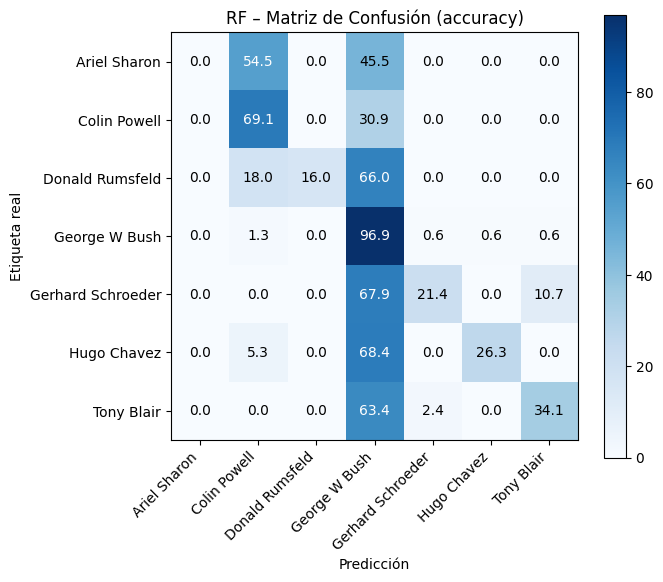

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.66      0.69      0.68        68
  Donald Rumsfeld       1.00      0.16      0.28        50
    George W Bush       0.56      0.97      0.71       159
Gerhard Schroeder       0.75      0.21      0.33        28
      Hugo Chavez       0.83      0.26      0.40        19
       Tony Blair       0.78      0.34      0.47        41

         accuracy                           0.60       387
        macro avg       0.65      0.38      0.41       387
     weighted avg       0.65      0.60      0.54       387



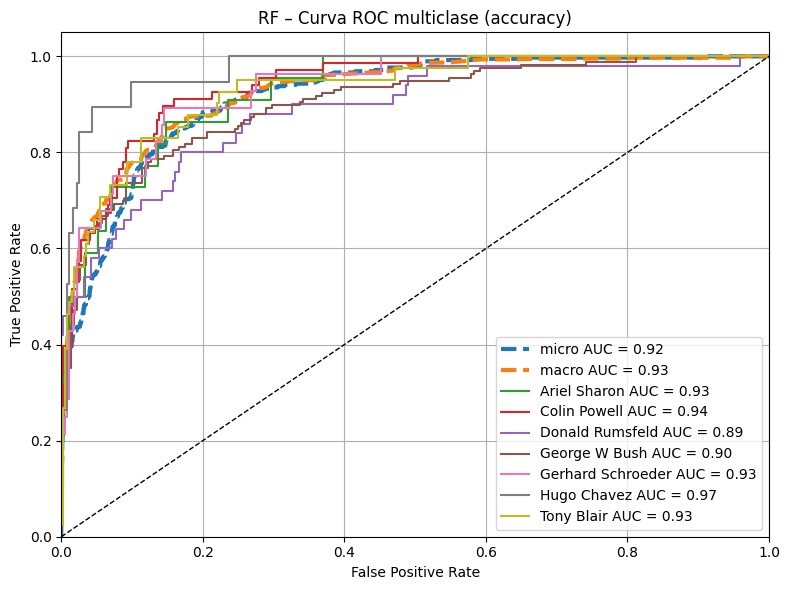


📊 Evaluación (RandomForest optimizado por f1_macro)


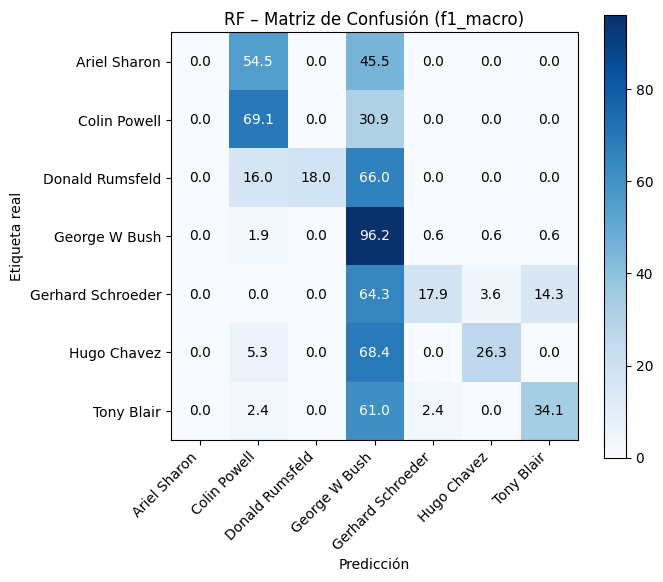

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.65      0.69      0.67        68
  Donald Rumsfeld       1.00      0.18      0.31        50
    George W Bush       0.56      0.96      0.71       159
Gerhard Schroeder       0.71      0.18      0.29        28
      Hugo Chavez       0.71      0.26      0.38        19
       Tony Blair       0.74      0.34      0.47        41

         accuracy                           0.60       387
        macro avg       0.63      0.37      0.40       387
     weighted avg       0.64      0.60      0.54       387



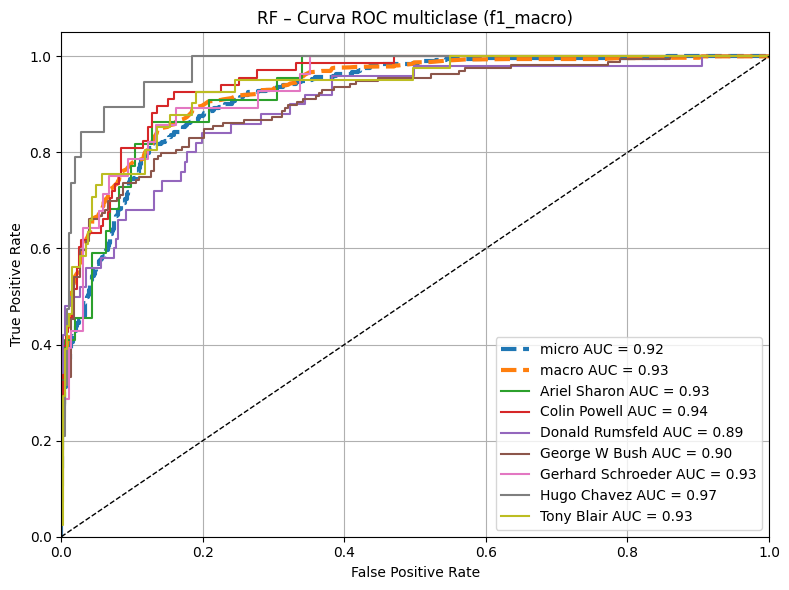


📊 Evaluación (RandomForest optimizado por roc_auc_ovr)


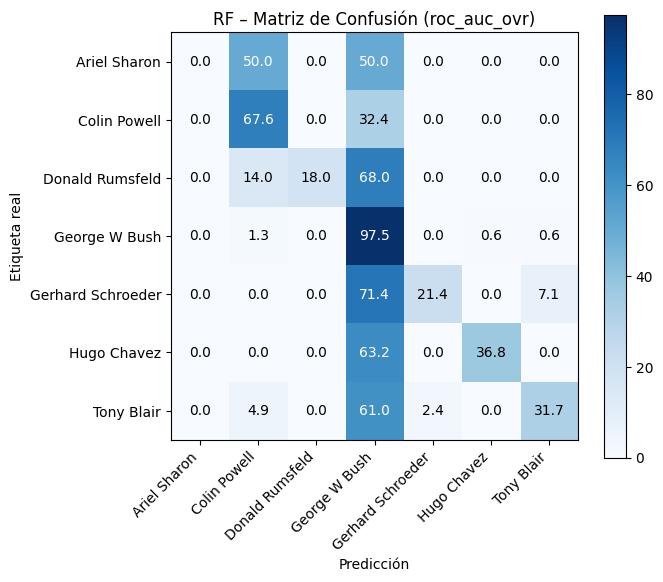

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.68      0.68      0.68        68
  Donald Rumsfeld       1.00      0.18      0.31        50
    George W Bush       0.56      0.97      0.71       159
Gerhard Schroeder       0.86      0.21      0.34        28
      Hugo Chavez       0.88      0.37      0.52        19
       Tony Blair       0.81      0.32      0.46        41

         accuracy                           0.61       387
        macro avg       0.68      0.39      0.43       387
     weighted avg       0.67      0.61      0.55       387



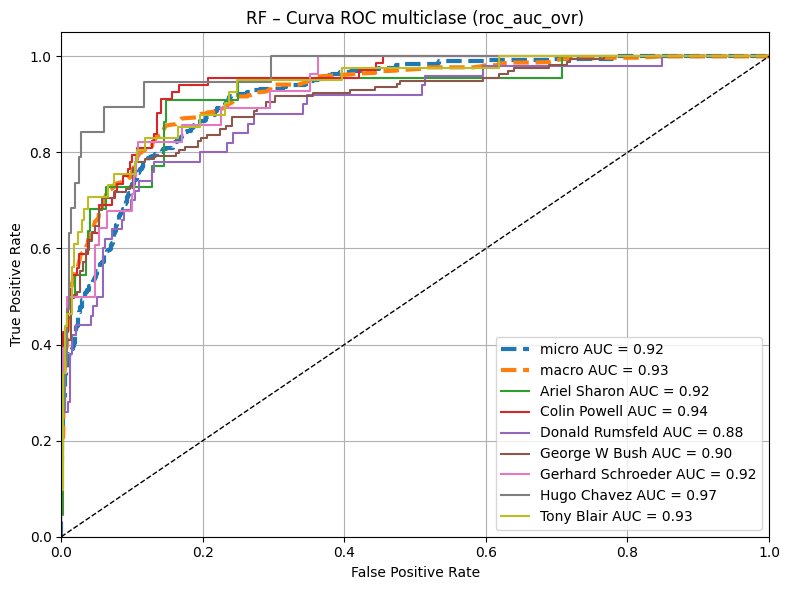

In [ ]:
# ==============================================================
#  RANDOMFOREST (rápido) – Optuna + CV-5 + Métricas + ROC
# ==============================================================

# --- IMPORTACIONES ---
import optuna, numpy as np, matplotlib.pyplot as plt
from functools import partial
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, accuracy_score, f1_score,
                             roc_auc_score)
from sklearn.utils.multiclass import unique_labels

# --- VALIDACIÓN CRUZADA ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- FUNCIÓN OBJETIVO ---
def objective(trial, X, y, scoring):
    rf_params = dict(
        n_estimators      = trial.suggest_int("n_estimators", 120, 280, step=40),
        max_depth         = trial.suggest_int("max_depth", 8, 25),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 12),
        min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 6),
        max_features      = trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        n_jobs            = -1,
        random_state      = 42
    )

    model = Pipeline([
        ("scaler", MinMaxScaler()),               # homogeno con resto de modelos
        ("classifier", RandomForestClassifier(**rf_params))
    ])

    return cross_val_score(model, X, y,
                           cv=cv, scoring=scoring,
                           n_jobs=-1, error_score=np.nan).mean()

# --- OPTIMIZACIÓN ---
pruner = optuna.pruners.MedianPruner(n_startup_trials=4, n_warmup_steps=1)
resultados_rf = {}
for metric in ["accuracy", "f1_macro", "roc_auc_ovr"]:
    print(f"\n🔍 Optimizando para: {metric}")
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(partial(objective, X=Xtrain, y=ytrain, scoring=metric),
                   n_trials=15, timeout=240)          # ≤ 4 min

    best = [t for t in study.trials if t.state.name == "COMPLETE"]
    bt   = max(best, key=lambda t: t.value)
    resultados_rf[metric] = {"score": bt.value, "params": bt.params}

# --- EVALUACIÓN EN TEST ---
target_names = lfw_people.target_names
ytest_bin    = label_binarize(ytest, classes=np.unique(ytrain))

for metric, info in resultados_rf.items():
    print(f"\n📊 Evaluación (RandomForest optimizado por {metric})")
    p = info["params"]

    rf = RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            n_jobs=-1, random_state=42)

    modelo = Pipeline([("scaler", MinMaxScaler()), ("classifier", rf)])
    modelo.fit(Xtrain, ytrain)

    # ---------- PREDICCIÓN ----------
    y_pred  = modelo.predict(Xtest)
    y_score = modelo.predict_proba(Xtest)

    # ---------- MATRIZ DE CONFUSIÓN ----------
    cm = 100 * confusion_matrix(ytest, y_pred, normalize="true")
    lbls = target_names[unique_labels(ytest, y_pred)]
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, cmap=plt.cm.Blues); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(lbls)), yticks=np.arange(len(lbls)),
           xticklabels=lbls, yticklabels=lbls,
           xlabel="Predicción", ylabel="Etiqueta real",
           title=f"RF – Matriz de Confusión ({metric})")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.1f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

    # ---------- REPORTE ----------
    print(classification_report(ytest, y_pred, target_names=target_names))

    # ---------- CURVAS ROC ----------
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = ytest_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"], "--", lw=3,
             label=f"micro AUC = {roc_auc['micro']:.2f}")
    plt.plot(fpr["macro"], tpr["macro"], "--", lw=3,
             label=f"macro AUC = {roc_auc['macro']:.2f}")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1.5,
                 label=f"{target_names[i]} AUC = {roc_auc[i]:.2f}")
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"RF – Curva ROC multiclase ({metric})")
    plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
    plt.show()
